# Quiz 4

Estudiantes:

- Alonso Araya Calvo
- Pedro Soto
- Sofia Oviedo

# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from scipy import stats
from scipy.spatial.distance import jensenshannon
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

# Cargando dataset

In [2]:
#tomado de https://www.kaggle.com/code/wailinnoo/intrusion-detection-system-using-kdd99-dataset
import pandas as pd
from tensorflow.keras.utils import get_file

try:
    path = get_file('kddcup.data_10_percent.gz',
                    origin='http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz')
except:
    print('Error downloading')
    raise

print(path)

# This file is a CSV, just no CSV extension or headers
# Download from: http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html
pd_data_frame = pd.read_csv(path, header=None)

# The CSV file has no column heads, so add them
pd_data_frame.columns = [
    'duration',
    'protocol_type',
    'service',
    'flag',
    'src_bytes',
    'dst_bytes',
    'land',
    'wrong_fragment',
    'urgent',
    'hot',
    'num_failed_logins',
    'logged_in',
    'num_compromised',
    'root_shell',
    'su_attempted',
    'num_root',
    'num_file_creations',
    'num_shells',
    'num_access_files',
    'num_outbound_cmds',
    'is_host_login',
    'is_guest_login',
    'count',
    'srv_count',
    'serror_rate',
    'srv_serror_rate',
    'rerror_rate',
    'srv_rerror_rate',
    'same_srv_rate',
    'diff_srv_rate',
    'srv_diff_host_rate',
    'dst_host_count',
    'dst_host_srv_count',
    'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate',
    'dst_host_srv_serror_rate',
    'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate',
    'outcome'
]

/Users/aaraya/git/KDD99-TLP/.venv/lib/python3.9/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/Users/aaraya/git/KDD99-TLP/.venv/lib/python3.9/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/Users/aaraya/git/KDD99-TLP/.venv/lib/python3.9/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/resource_handle.proto. Please 

/Users/aaraya/.keras/datasets/kddcup.data_10_percent.gz


# Limpieza del dataset y generación de subset del dataset

In [3]:
# For now, just drop NA's (rows with missing values), in case there are
pd_data_frame.dropna(inplace=True, axis=1)

# Checking for DUPLICATE values
pd_data_frame.drop_duplicates(keep='first', inplace=True)

In [4]:
# Filter the DataFrame to keep only 'normal.' and 'back.' outcomes
filtered_df = pd_data_frame[pd_data_frame['outcome'].isin(['normal.', 'back.'])].copy()

In [5]:
list_nominal_features = ["flag", "protocol_type", "service"]

# Apply one-hot encoding to the nominal features
df_encoded = pd.get_dummies(filtered_df, columns=list_nominal_features)

# Convert boolean columns (from one-hot encoding) to integers (0 or 1) in df_encoded
for col in df_encoded.columns:
    if df_encoded[col].dtype == 'bool':
        df_encoded[col] = df_encoded[col].astype(int)

In [6]:
# Separo los datos en ataques y normales en diferentes dataframes
df_attacks = df_encoded[df_encoded['outcome'] == 'back.'].copy()
df_no_attacks = df_encoded[df_encoded['outcome'] == 'normal.'].copy()

# Funciones Utilitarias

In [7]:
# Util para mostrar dataframes completos sin el resumen que se hace por defecto
def display_dataframe_completely(df):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display(df)

# Parte 1

Elija las 5 caracteristicas con mayor distancia entre las densidades de los ataques y mensajes normales en el conjunto de datos.

In [8]:
# Es necesario eliminar la columna de outcome para poder utilizar el dataset en pytorch, ya que es categórica
# y no es necesario realmente tenerla para calculos numéricos en la parte de Jensen Shannon, ya que al separar los datasets
# ya se sabe de cuál clase proviene.
df_attacks_without_outcome = df_attacks.drop('outcome', axis=1)
df_normal_without_outcome = df_no_attacks.drop('outcome', axis=1)

# Genero los tensores de cada dataframe para poder usarlos en pytorch
attack_without_outcomes_column_names = df_attacks_without_outcome.columns
attack_tensor = torch.tensor(df_attacks_without_outcome.values, dtype=torch.float32)

normal_without_outcomes_column_names = df_normal_without_outcome.columns
no_attack_tensor = torch.tensor(df_normal_without_outcome.values, dtype=torch.float32)

In [9]:
def generate_feature_histogram_and_calculate_jensen_shannon(df_normal, df_backdoor, feature_names, bins=30):
    """
    Calcula la divergencia de Jensen-Shannon entre características de tráfico normal y ataques backdoor.
    
    Esta función calcula histogramas para cada característica en los conjuntos de datos normales 
    y de ataques backdoor, los normaliza para crear distribuciones de probabilidad y calcula 
    la divergencia de Jensen-Shannon para medir cada característica.
    
    Parámetros:
    -----------
    df_normal : DataFrame que contiene datos de tráfico de red normal
    df_backdoor : DataFrame que contiene datos de tráfico de ataques backdoor
    feature_names : Lista de nombres de columnas de características a analizar
    bins : Número de bins a usar para el cálculo del histograma
        
    Retorna:
    --------
        DataFrame con columnas:
        - 'Feature': Nombres de las características
        - 'DistanciaJS': Distancias de Jensen-Shannon, ordenadas de mayor a menor
    """
    js_distances = []

    for feat in feature_names:
        # Se obtienen los valores numéricos de las dos clases
        normal_df_values = df_normal[feat].values
        backdoor_df_values = df_backdoor[feat].values

        # Se obtiene el rango común de histograma para ambas clases
        limits_histogram = (min(normal_df_values.min(), backdoor_df_values.min()),
                            max(normal_df_values.max(), backdoor_df_values.max()))

        # Se calcula el histograma de las dos clases y se normaliza para obtener las densidades
        hist_normal, _ = np.histogram(normal_df_values, bins=bins, range=limits_histogram)
        hist_backdoor, _ = np.histogram(backdoor_df_values, bins=bins, range=limits_histogram)

        hist_normal = hist_normal / hist_normal.sum()
        hist_backdoor = hist_backdoor / hist_backdoor.sum()

        # Se calcula la distancia de Jensen Shannon entre las dos clases
        jsd = jensenshannon(hist_normal, hist_backdoor)
        js_distances.append(jsd)

    # Dataframe con tabla de distancias de Jensen Shannon para todas las features
    js_df = pd.DataFrame({
        "Feature": feature_names,
        "DistanciaJS": js_distances
    }).sort_values(by="DistanciaJS", ascending=False)

    return js_df

## Explicación del Codigo

Esta funcion nos va a ayudar a poder medir la distancia de Jensen Shannon entre nuestros dos conjuntos de datos de
tráfico normal y de ataque backdoor. Para este efecto se obtiene los valores numericos de cada caracteristica y
se generan los histogramas correspondientes de cada conjunto por medio de la funcion `histogram` de numpy,
lo siguiente es que se normalizan los valores y se utilizan de entrada para la funcion `jensenshannon` de scipy
para calcular la distancia entre las dos caracteristicas, todo esto se realiza para todas las caracteristicas del
dataset.

Finalmente, retorna una lista ordenada de las caracteristicas con mayor distancia Jensen Shannon. Este cálculo va de 0 a 1 y permite recopilar cuáles son las caracteristicas más discriminativas que podrian ser más utiles para en un arbol de decision, esto va a ayudar a descartar caracteristicas que no sean de mucho interes, optimizar el arbol con las caracteristicas más importantes y ser más eficiente al utilizar menos datos a tomar en cuenta.

## Resultados

En este caso como se puede observar en los resultados de la ejecucion de la siguiente celda, las cinco mejores caracteristicas fueron:

```
	Feature	                  DistanciaJS
6	hot	                    0.813179
37	dst_host_srv_rerror_rate  0.466678
36	dst_host_rerror_rate	  0.459732
24	srv_rerror_rate	          0.373477
60	service_http	          0.346864
```

Proponiendo a estas cinco como las que podrian ayudar a distinguir mejor el tráfico entre normal y backdoor, dado que el cálculo de Jensen Shannon nos dice cuáles podrian ser más discriminativas entre la clase normal y de ataque como candidatas a para tener mejor rendimiento para el modelo.

In [10]:
js_df = generate_feature_histogram_and_calculate_jensen_shannon(df_normal_without_outcome, df_attacks_without_outcome,
                                                                attack_without_outcomes_column_names)
display_dataframe_completely(js_df)

,Feature,DistanciaJS
6,hot,0.813179
37,dst_host_srv_rerror_rate,0.466678
36,dst_host_rerror_rate,0.459732
24,srv_rerror_rate,0.373477
60,service_http,0.346864
30,dst_host_same_srv_rate,0.328221
29,dst_host_srv_count,0.298668
33,dst_host_srv_diff_host_rate,0.297726
27,srv_diff_host_rate,0.285225
23,rerror_rate,0.284472


# Parte 2

Parta los datos en una particion de entrenamiento (70%) y otra de prueba (30 %).


## Explicación del Codigo

En la siguiente celda se utiliza la funcion de Scikit-learn con el fin de poder generar dos particiones, una de entrenamiento y una de prueba con una proporcion de 70%/30%. Para este efecto se separó las etiquetas de la clase outcome, con los datos del dataset y se enviaron a la funcion `train_test_split` la cual genera una particion de los datos en conjunto con una semilla para poder experimentar en otras iteraciones y con estratificacion que permite mantener las proporciones de las clases, algo especial para este dataset, ya que KD99 es un poco desbalanceado en tamaño de datos por clase.

## Resultados

En la salida se pueden observar datos importantes del dataset, pero se adjuntan en el siguiente bloque como referencia:

```
Conjunto de Entrenamiento (70%):
- Observaciones: 62159
- Características: 75
- Distribución de clases: {'normal.': 61481, 'back.': 678}
- Proporción normal/backdoor: {'normal.': 0.9890924886178992, 'back.': 0.010907511382100742}

Conjunto de Prueba (30%):
- Observaciones: 26640
- Características: 75
- Distribución de clases: {'normal.': 26350, 'back.': 290}
- Proporción normal/backdoor: {'normal.': 0.9891141141141141, 'back.': 0.010885885885885885}

Verificación de proporciones:
- Dataset original: {'normal.': 0.9890990990990991, 'back.': 0.0109009009009009}
- Entrenamiento: {'normal.': 0.9890924886178992, 'back.': 0.010907511382100742}
- Prueba: {'normal.': 0.9891141141141141, 'back.': 0.010885885885885885}
```

Como se puede observar KD99 presenta una desproporcion en las clases, en este caso la normal es mucho más grande que la de tipo backdoor, pero presenta una realidad en la ciberseguridad en la cual los ataques son mucho menores al tráfico normal. Además, se muestra la proporcion de las clases en el dataset original, entrenamiento y prueba, demostrando que todos tienen una estructura similar.

Estos datos nos van a ayudar en los siguientes puntos del quiz para poder utilizar datos de evaluación y prueba para generar los cálculos.


In [11]:
X = df_encoded.drop('outcome', axis=1)
y = df_encoded['outcome']

# Genera las particiones de entrenamiento y prueba con estratificación
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    train_size=0.7,
    random_state=42,
    stratify=y
)

print(f"\nConjunto de Entrenamiento (70%):")
print(f"- Observaciones: {len(X_train)}")
print(f"- Características: {X_train.shape[1]}")
print(f"- Distribución de clases: {y_train.value_counts().to_dict()}")
print(f"- Proporción normal/backdoor: {y_train.value_counts(normalize=True).to_dict()}")

print(f"\nConjunto de Prueba (30%):")
print(f"- Observaciones: {len(X_test)}")
print(f"- Características: {X_test.shape[1]}")
print(f"- Distribución de clases: {y_test.value_counts().to_dict()}")
print(f"- Proporción normal/backdoor: {y_test.value_counts(normalize=True).to_dict()}")

# Verificar que las proporciones se mantuvieron
print(f"\nVerificación de proporciones:")
print(f"- Dataset original: {y.value_counts(normalize=True).to_dict()}")
print(f"- Entrenamiento: {y_train.value_counts(normalize=True).to_dict()}")
print(f"- Prueba: {y_test.value_counts(normalize=True).to_dict()}")


Conjunto de Entrenamiento (70%):
- Observaciones: 62159
- Características: 75
- Distribución de clases: {'normal.': 61481, 'back.': 678}
- Proporción normal/backdoor: {'normal.': 0.9890924886178992, 'back.': 0.010907511382100742}

Conjunto de Prueba (30%):
- Observaciones: 26640
- Características: 75
- Distribución de clases: {'normal.': 26350, 'back.': 290}
- Proporción normal/backdoor: {'normal.': 0.9891141141141141, 'back.': 0.010885885885885885}

Verificación de proporciones:
- Dataset original: {'normal.': 0.9890990990990991, 'back.': 0.0109009009009009}
- Entrenamiento: {'normal.': 0.9890924886178992, 'back.': 0.010907511382100742}
- Prueba: {'normal.': 0.9891141141141141, 'back.': 0.010885885885885885}


# Parte 3

- Por cada caracteristica, ajuste los parametros de un modelo Gaussiano o un modelo parametrico
más adecuado, para los datos de mensajes normales. Reporte los parametros del modelo
para cada caracteristica y grafiquelos junto con el histograma de los datos. Use los datos de
entrenamiento para ello.

Top 5 características más discriminativas según Jensen-Shannon:
  1. hot (JS = 0.813179)
  2. dst_host_srv_rerror_rate (JS = 0.466678)
  3. dst_host_rerror_rate (JS = 0.459732)
  4. srv_rerror_rate (JS = 0.373477)
  5. service_http (JS = 0.346864)

=== Filtrado de datos normales de entrenamiento ===
Datos normales de entrenamiento: 61481 muestras

=== Ajuste de parametros exponenciales ===

--- Característica 1/5: hot ---
  Estadísticas descriptivas:
    - Media muestral: 0.047966
    - Desv. estándar muestral: 0.885394
    - Rango: [0.000000, 30.000000]
    - Número de muestras: 61481
  Parámetros del modelo Exponencial (MLE):
    - λ (rate parameter): 20.848084
    - Escala (1/λ): 0.047966
    - Localización: 0.000000
    - Media teórica: 0.047966
    - Distancia Jensen-Shannon: 0.813179


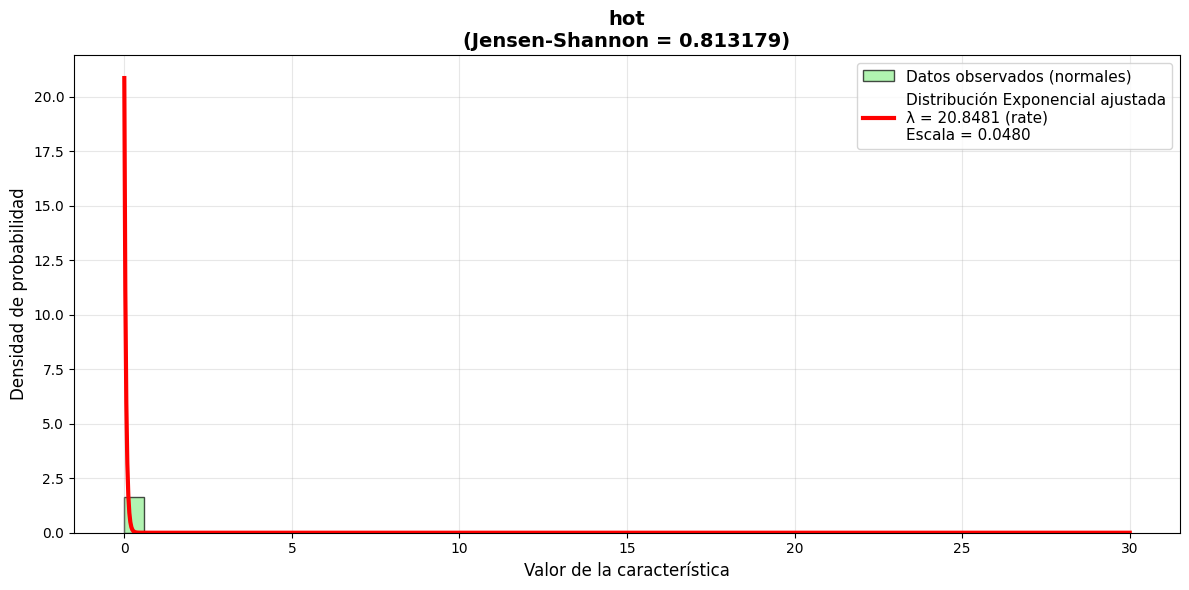


--- Característica 2/5: dst_host_srv_rerror_rate ---
  Estadísticas descriptivas:
    - Media muestral: 0.054776
    - Desv. estándar muestral: 0.215646
    - Rango: [0.000000, 1.000000]
    - Número de muestras: 61481
  Parámetros del modelo Exponencial (MLE):
    - λ (rate parameter): 18.256026
    - Escala (1/λ): 0.054776
    - Localización: 0.000000
    - Media teórica: 0.054776
    - Distancia Jensen-Shannon: 0.466678


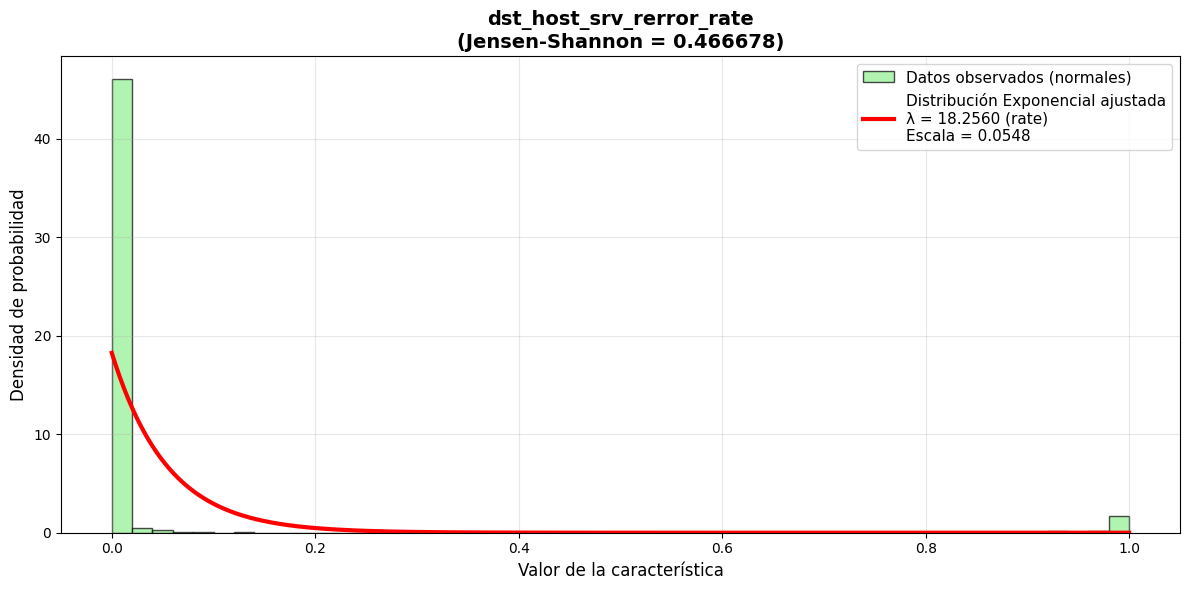


--- Característica 3/5: dst_host_rerror_rate ---
  Estadísticas descriptivas:
    - Media muestral: 0.056763
    - Desv. estándar muestral: 0.222188
    - Rango: [0.000000, 1.000000]
    - Número de muestras: 61481
  Parámetros del modelo Exponencial (MLE):
    - λ (rate parameter): 17.617090
    - Escala (1/λ): 0.056763
    - Localización: 0.000000
    - Media teórica: 0.056763
    - Distancia Jensen-Shannon: 0.459732


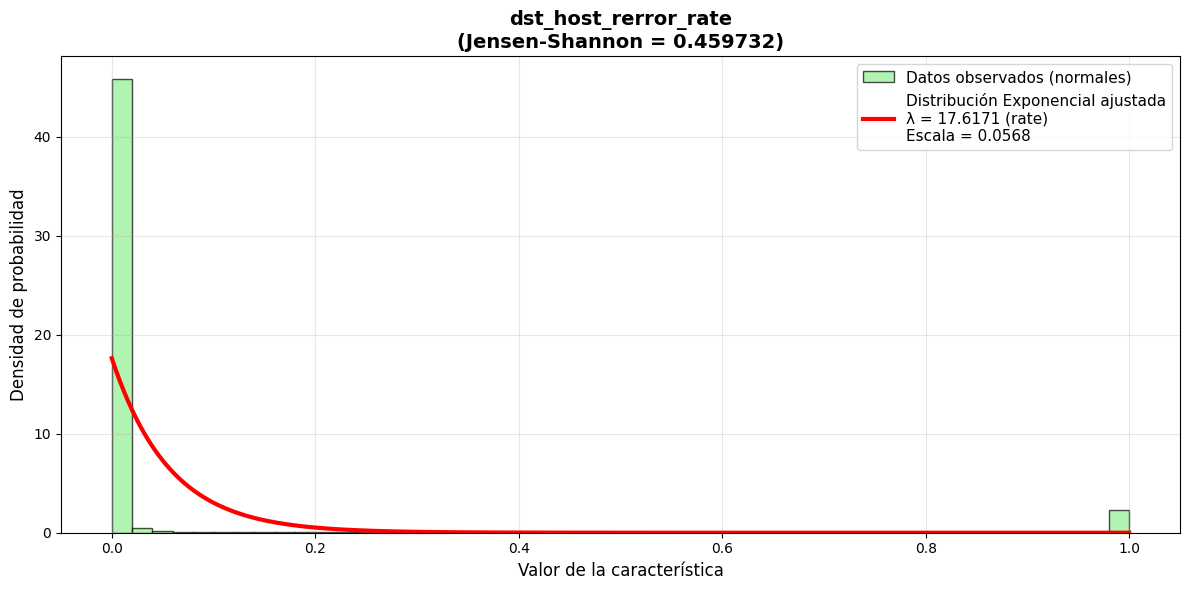


--- Característica 4/5: srv_rerror_rate ---
  Estadísticas descriptivas:
    - Media muestral: 0.055158
    - Desv. estándar muestral: 0.225429
    - Rango: [0.000000, 1.000000]
    - Número de muestras: 61481
  Parámetros del modelo Exponencial (MLE):
    - λ (rate parameter): 18.129624
    - Escala (1/λ): 0.055158
    - Localización: 0.000000
    - Media teórica: 0.055158
    - Distancia Jensen-Shannon: 0.373477


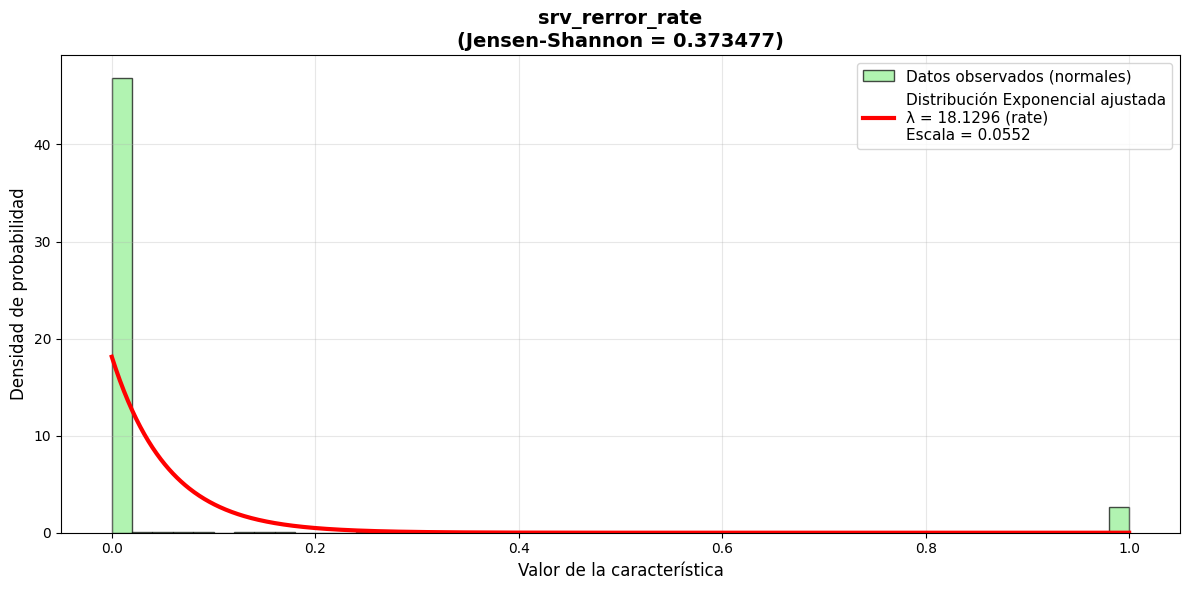


--- Característica 5/5: service_http ---
  Estadísticas descriptivas:
    - Media muestral: 0.692913
    - Desv. estándar muestral: 0.461289
    - Rango: [0.000000, 1.000000]
    - Número de muestras: 61481
  Parámetros del modelo Exponencial (MLE):
    - λ (rate parameter): 1.443182
    - Escala (1/λ): 0.692913
    - Localización: 0.000000
    - Media teórica: 0.692913
    - Distancia Jensen-Shannon: 0.346864


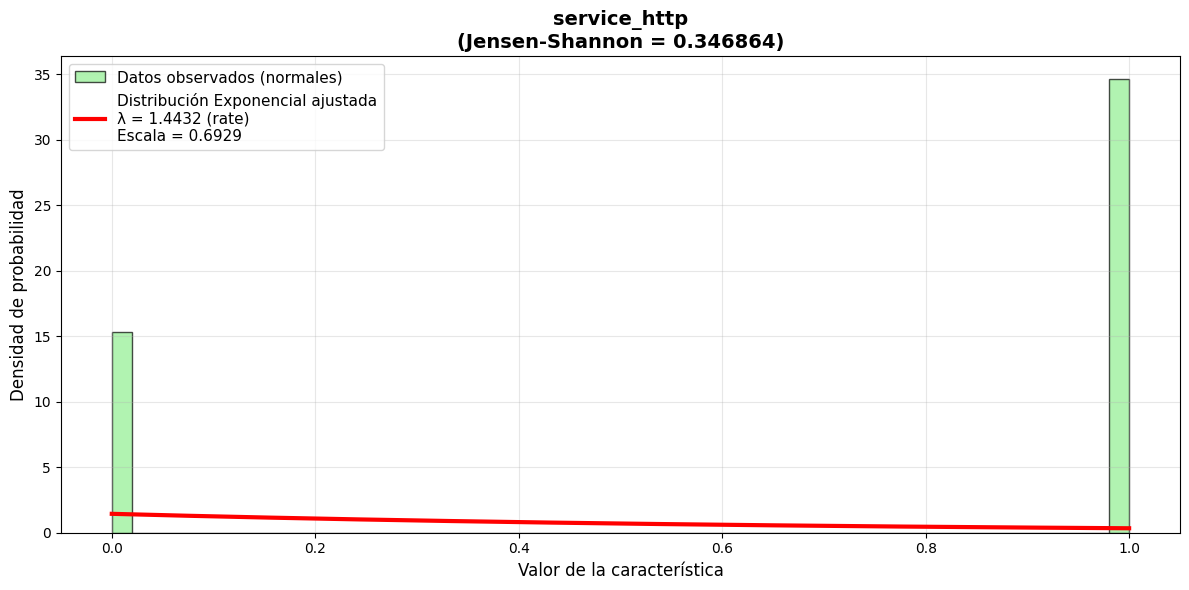


=== Tabla resumen de parametros exponenciales (top 5 caracteristicas) ===


,lambda,scale,mean_theoretical,mean_empirical,jensen_shannon,n_samples
hot,20.848084,0.047966,0.047966,0.047966,0.813179,61481
dst_host_srv_rerror_rate,18.256026,0.054776,0.054776,0.054776,0.466678,61481
dst_host_rerror_rate,17.617090,0.056763,0.056763,0.056763,0.459732,61481
srv_rerror_rate,18.129624,0.055158,0.055158,0.055158,0.373477,61481
service_http,1.443182,0.692913,0.692913,0.692913,0.346864,61481


In [12]:
# Obtener el top 5 características calculadas anteriormente en la función de distancia de Jensen Shannon
top_5_features = js_df.head(5)['Feature'].tolist()
print(f"Top 5 características más discriminativas según Jensen-Shannon:")
for i, feature in enumerate(top_5_features, 1):
    js_distance = js_df[js_df['Feature'] == feature]['DistanciaJS'].iloc[0]
    print(f"  {i}. {feature} (JS = {js_distance:.6f})")

print(f"\n=== Filtrado de datos normales de entrenamiento ===")
# Filtrar solo los datos normales del conjunto de entrenamiento
X_train_normal = X_train[y_train == 'normal.']
print(f"Datos normales de entrenamiento: {len(X_train_normal)} muestras")

exponential_params_top5 = {}


def plot_histogram_with_exponential_top5(data, feature_name, loc, scale, js_distance):
    """
    Genera un histograma normalizado superpuesto con una curva de distribución exponencial ajustada.
    
    Esta función visualiza la distribución de una característica específica junto con
    su modelo exponencial teórico, mostrando métricas de calidad del ajuste.
    
    Parameters
    ----------
    data : Los datos observados de la característica a visualizar. Debe contener valores numéricos.
    feature_name : Nombre descriptivo de la característica que será usado como título del gráfico.
    loc : Parámetro de localización de la distribución exponencial, es el punto de inicio de la distribución.
    scale : Parámetro de escala de la distribución exponencial (1/λ donde λ es la tasa de decaimiento).
    js_distance : Distancia Jensen-Shannon que mide la similitud entre la distribución y la 
        exponencial teórica.
    """
    plt.figure(figsize=(12, 6))

    # Histograma normalizado
    plt.hist(data, bins=50, density=True, alpha=0.7, color='lightgreen',
             edgecolor='black', label='Datos observados (normales)')

    # Curva exponencial ajustada
    x = np.linspace(data.min(), data.max(), 1000)
    exponential_curve = stats.expon.pdf(x, loc=loc, scale=scale)
    plt.plot(x, exponential_curve, 'red', linewidth=3,
             label=f'Distribución Exponencial ajustada\nλ = {1 / scale:.4f} (rate)\nEscala = {scale:.4f}')

    plt.title(f'{feature_name}\n(Jensen-Shannon = {js_distance:.6f})', fontsize=14, fontweight='bold')
    plt.xlabel('Valor de la característica', fontsize=12)
    plt.ylabel('Densidad de probabilidad', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# Procesar cada una de las 5 mejores características
print(f"\n=== Ajuste de parametros exponenciales ===")
for i, feature in enumerate(top_5_features, 1):
    print(f"\n--- Característica {i}/5: {feature} ---")

    # Obtener los datos numéricos de la característica
    data = X_train_normal[feature].values

    # Remover valores NaN si existen
    data_clean = data[~np.isnan(data)]

    # Para distribución exponencial, los datos deben ser no negativos
    # por ende se transforman los datos para que sean no negativos
    if np.min(data_clean) < 0:
        print(f"  Datos con valores negativos. Aplicando transformación: x' = x - min(x)")
        data_transformed = data_clean - np.min(data_clean)
    else:
        data_transformed = data_clean

    if len(data_transformed) == 0:
        print(f"  Sin datos válidos para {feature}")
        continue

    # Calcular estadísticas
    mean_val = np.mean(data_transformed)
    std_val = np.std(data_transformed, ddof=1)
    min_val = np.min(data_transformed)
    max_val = np.max(data_transformed)

    # Ajustar distribución exponencial usando Maximum Likelihood Estimation
    # stats.expon.fit devuelve (loc, scale) donde scale = 1/λ
    loc, scale = stats.expon.fit(data_transformed)
    lambda_param = 1 / scale  # Parametro de tasa

    # Obtener la distancia Jensen-Shannon que calculamos anteriormente
    js_distance = js_df[js_df['Feature'] == feature]['DistanciaJS'].iloc[0]

    # Almacenar parámetros
    exponential_params_top5[feature] = {
        'lambda': lambda_param,
        'scale': scale,
        'loc': loc,
        'mean_theoretical': scale,  # Para exponencial, media = scale = 1/λ
        'mean_empirical': mean_val,
        'std_empirical': std_val,
        'min': min_val,
        'max': max_val,
        'n_samples': len(data_transformed),
        'jensen_shannon': js_distance,
        'data_transformed': np.min(data_clean) < 0
    }

    print(f"  Estadísticas descriptivas:")
    print(f"    - Media muestral: {mean_val:.6f}")
    print(f"    - Desv. estándar muestral: {std_val:.6f}")
    print(f"    - Rango: [{min_val:.6f}, {max_val:.6f}]")
    print(f"    - Número de muestras: {len(data_transformed)}")
    if np.min(data_clean) < 0:
        print(f"    - Transformación aplicada: x' = x - {np.min(data_clean):.6f}")

    print(f"  Parámetros del modelo Exponencial (MLE):")
    print(f"    - λ (rate parameter): {lambda_param:.6f}")
    print(f"    - Escala (1/λ): {scale:.6f}")
    print(f"    - Localización: {loc:.6f}")
    print(f"    - Media teórica: {scale:.6f}")
    print(f"    - Distancia Jensen-Shannon: {js_distance:.6f}")

    # Generación de gráficos
    plot_histogram_with_exponential_top5(data_transformed, feature, loc, scale, js_distance)

print(f"\n=== Tabla resumen de parametros exponenciales (top 5 caracteristicas) ===")
# Crear dataframe de resumen
params_exp_top5_df = pd.DataFrame.from_dict(exponential_params_top5, orient='index')
params_exp_top5_df = params_exp_top5_df.round(6)
params_exp_top5_df = params_exp_top5_df.sort_values('jensen_shannon', ascending=False)

# Seleccionar columnas más importantes para mostrar
display_columns = ['lambda', 'scale', 'mean_theoretical', 'mean_empirical', 'jensen_shannon', 'n_samples']
display_dataframe_completely(params_exp_top5_df[display_columns])

## Explicación del Codigo

De los calculos de las celdas anteriores se puede observar la funcionalidad que nos da los resultados de ajustar los parametros de un modelo exponencial para cada caracteristica de los datos de entrenamiento de la clase normal. Para este efecto se filtró primero los datos de entrenamiento a solo los que tuvieran la etiqueta `normal`. Después de ello se creó una funcion utilitaria `plot_histogram_with_exponential_top5` para poder generar los graficos, estos graficos contienen un histograma superpuesto a la curva de distribucion exponencial ajustada de la caracteristica enviada por sus parametros.

Finalmente, para poder generar todos los calculos se itera sobre las cinco mejores caracteristicas encontradas anteriormente en nuestra funcion de cálculo de Jensen Shannon y se obtienen los datos de entrenamiento de la clase normal, se limpian si es necesario, se calculan los diferentes momentos estadisticos como maximos, minimos, media aritmetica y la desviacion estandar muestral, para ajustar la distribucion exponencial se utiliza la funcion de scipy `stats.expon.fit` y se guardan todos los parametros utilizados y los resultados en una variable para poder imprimir los resultados, además de una tabla de resumen con los parametros y cada caracteristica analizada.

## Interpretación de Resultados

De los resultados se muestra como la caracteristica `hot` tiene la tasa más alta, esto significa que los valores tienden a ser pequeños y concentrados cerca de cero, sugiriendo que son más dificiles de observar en el tráfico normal siendo esto una oportunidad para utilizarlos en la deteccion, ya que una anomalia se podria ver más facilmente. En cambio, la caracteristica `service_http` tiene la más baja, lo que sugiere que es más distribuido y con una mayor variabilidad para los datos normales.

En el valor de escala también es posible ver en promedio cuáles caracteristicas son esperadas por tráfico en cada porcentaje, como se puede observar la mayoria de caracteristicas tienen un valor bajo; sin embargo, `service_http` es un valor con porcentaje alto, lo que indica que es más tipico ver en el tráfico normal, confirmando que podria no ser tan buen candidato para discriminar.

De los resultados de la celda siguiente se puede observar nada más un resumen de los graficos calculados anteriormente y un resumen comparativo de los resultados de utilizar el modelo exponencial.




=== Grafico conjunto de las 5 mejores caracteristicas con modelos exponenciales ===


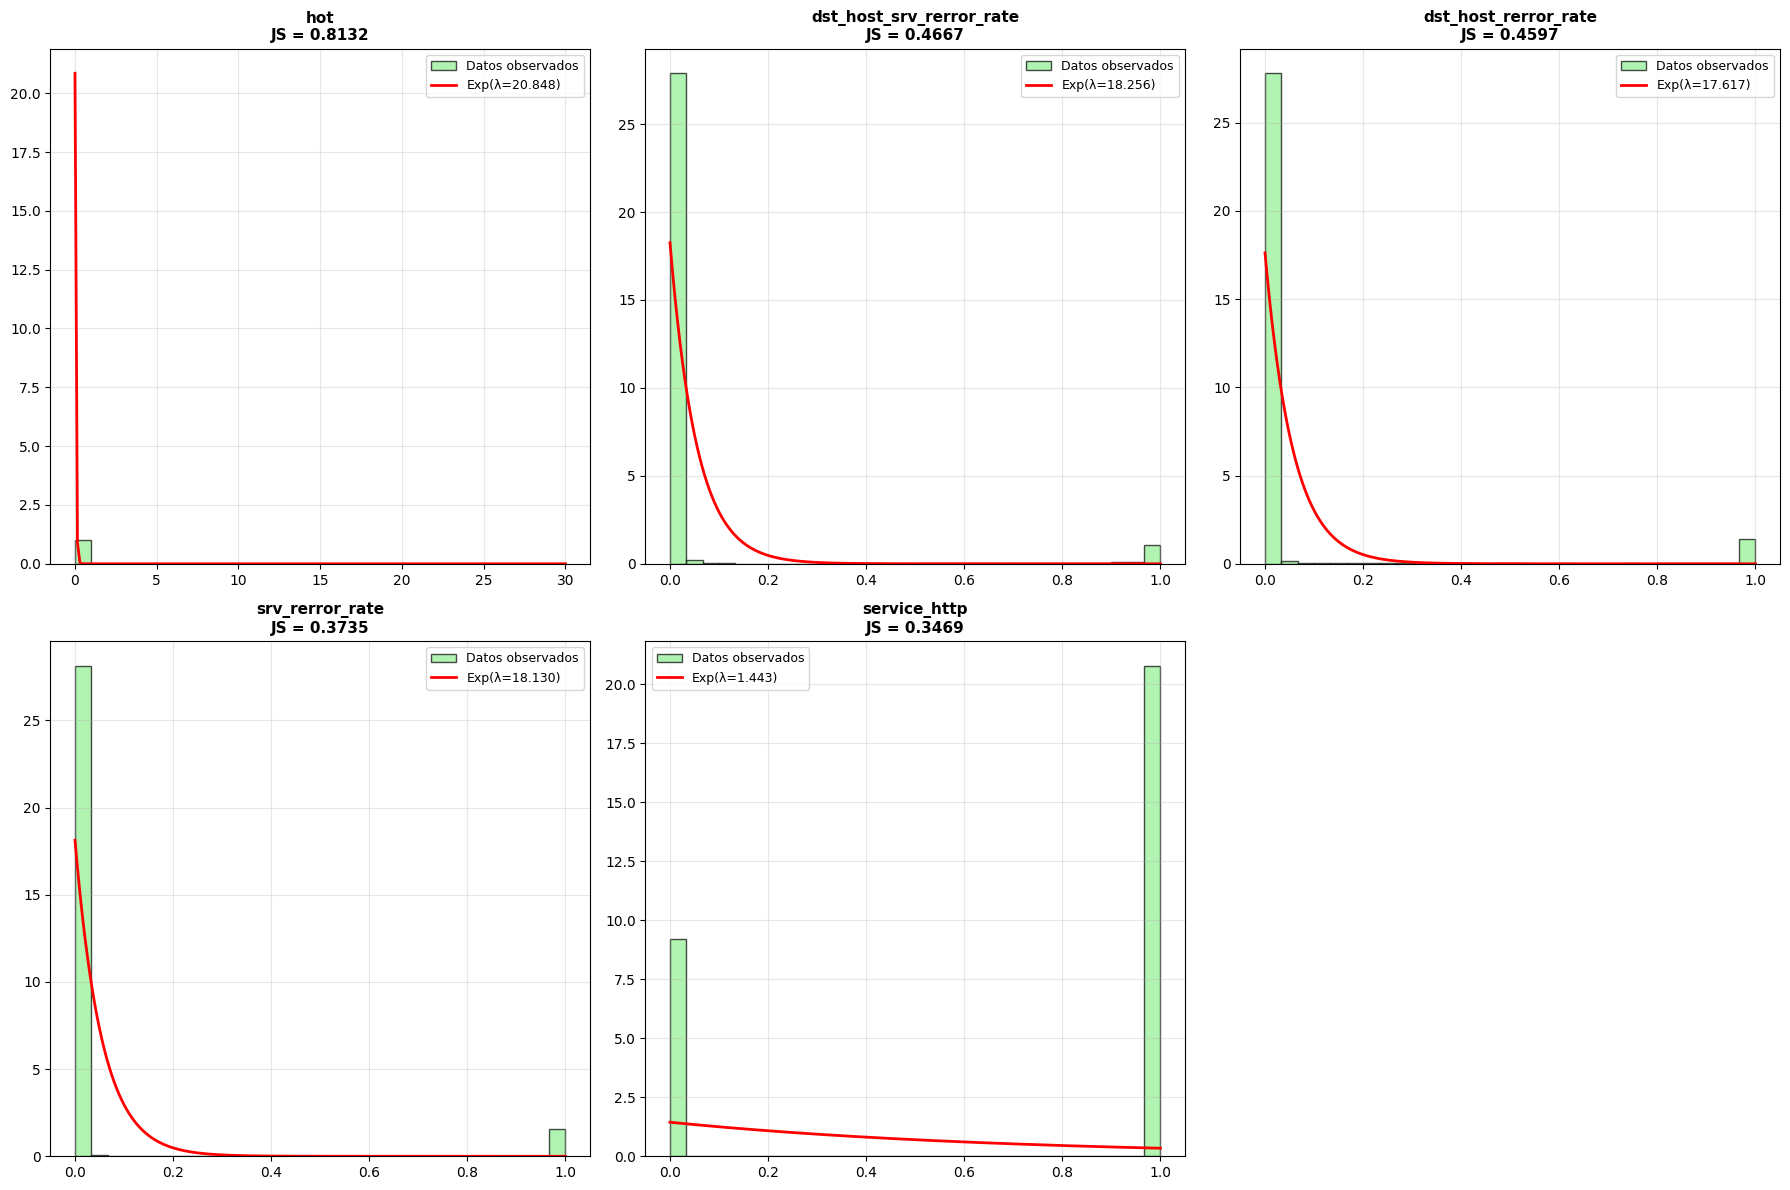


=== Analisis comparativo de parametros exponenciales ===
Característica con mayor tasa (λ): hot (λ = 20.8481)
Característica con menor tasa (λ): service_http (λ = 1.4432)
Media de tasas λ: 15.2588
Desviación estándar de tasas λ: 7.8246


In [13]:
print(f"\n=== Grafico conjunto de las 5 mejores caracteristicas con modelos exponenciales ===")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, feature in enumerate(top_5_features):
    data = X_train_normal[feature].values
    data_clean = data[~np.isnan(data)]

    # Aplicar transformación si es necesaria
    if np.min(data_clean) < 0:
        data_transformed = data_clean - np.min(data_clean)
    else:
        data_transformed = data_clean

    lambda_param = exponential_params_top5[feature]['lambda']
    scale = exponential_params_top5[feature]['scale']
    loc = exponential_params_top5[feature]['loc']
    js_distance = exponential_params_top5[feature]['jensen_shannon']

    # Histograma
    axes[i].hist(data_transformed, bins=30, density=True, alpha=0.7,
                 color='lightgreen', edgecolor='black', label='Datos observados')

    # Curva exponencial
    x = np.linspace(data_transformed.min(), data_transformed.max(), 200)
    exponential_curve = stats.expon.pdf(x, loc=loc, scale=scale)
    axes[i].plot(x, exponential_curve, 'red', linewidth=2,
                 label=f'Exp(λ={lambda_param:.3f})')

    axes[i].set_title(f'{feature}\nJS = {js_distance:.4f}', fontsize=11, fontweight='bold')
    axes[i].legend(fontsize=9)
    axes[i].grid(True, alpha=0.3)

# Ocultar el último subplot si no se usa
if len(top_5_features) < 6:
    axes[5].set_visible(False)

plt.tight_layout()
plt.show()

# Análisis comparativo de los parámetros
print(f"\n=== Analisis comparativo de parametros exponenciales ===")
print(
    f"Característica con mayor tasa (λ): {params_exp_top5_df['lambda'].idxmax()} (λ = {params_exp_top5_df['lambda'].max():.4f})")
print(
    f"Característica con menor tasa (λ): {params_exp_top5_df['lambda'].idxmin()} (λ = {params_exp_top5_df['lambda'].min():.4f})")
print(f"Media de tasas λ: {params_exp_top5_df['lambda'].mean():.4f}")
print(f"Desviación estándar de tasas λ: {params_exp_top5_df['lambda'].std():.4f}")

# Parte 4

Escoja 3 umbrales diferentes de aceptacion para comportamientos normales y con los datos
de prueba, usando cada una de las 5 caracteristicas por separado, calcule la verosimilitud y
discrimine entre ataques y comportamientos normales. Calcule la matriz de confusion. Comente
los resultados.


Umbrales basados en percentiles de la distribución exponencial: [5, 10, 20]%

Caracteristica 1/5: hot
Parámetros del modelo: λ=20.8481, escala=0.0480
Distancia Jensen-Shannon: 0.813179
Umbrales de verosimilitud calculados: ['19.805680', '18.763276', '16.678467']

--- Umbral 1/3: 5% (likelihood ≥ 19.805680) ---
Resultados:
  - Accuracy: 0.9940
  - Precision (detección de ataques): 0.6443
  - Recall (sensibilidad): 0.9931
  - Specificity (especificidad): 0.9940
  - F1-Score: 0.7815
  - Matriz de confusión:
    TN=26191 (Normal→Normal), FP=159 (Normal→Ataque)
    FN=2 (Ataque→Normal), TP=288 (Ataque→Ataque)


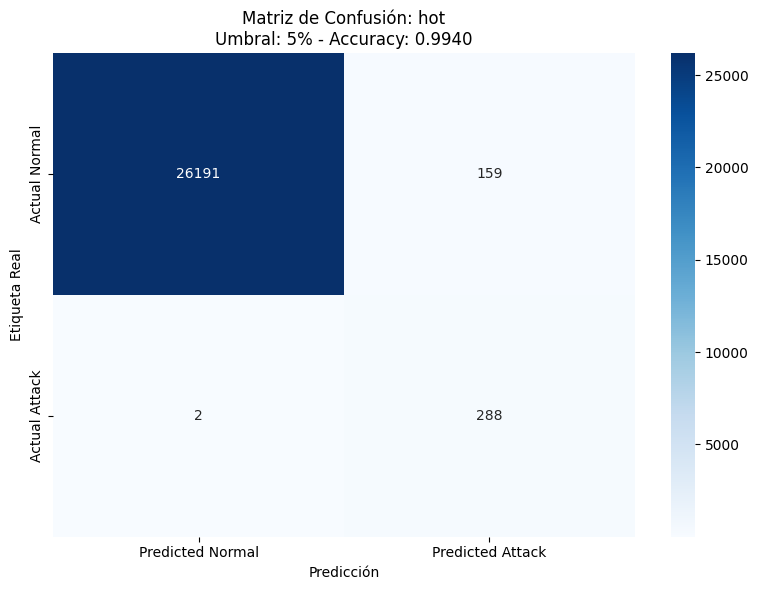


--- Umbral 2/3: 10% (likelihood ≥ 18.763276) ---
Resultados:
  - Accuracy: 0.9940
  - Precision (detección de ataques): 0.6443
  - Recall (sensibilidad): 0.9931
  - Specificity (especificidad): 0.9940
  - F1-Score: 0.7815
  - Matriz de confusión:
    TN=26191 (Normal→Normal), FP=159 (Normal→Ataque)
    FN=2 (Ataque→Normal), TP=288 (Ataque→Ataque)


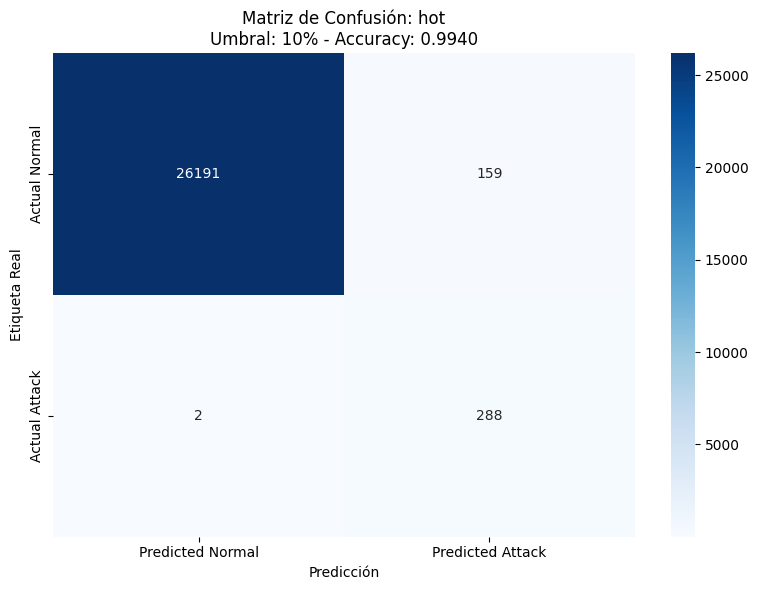


--- Umbral 3/3: 20% (likelihood ≥ 16.678467) ---
Resultados:
  - Accuracy: 0.9940
  - Precision (detección de ataques): 0.6443
  - Recall (sensibilidad): 0.9931
  - Specificity (especificidad): 0.9940
  - F1-Score: 0.7815
  - Matriz de confusión:
    TN=26191 (Normal→Normal), FP=159 (Normal→Ataque)
    FN=2 (Ataque→Normal), TP=288 (Ataque→Ataque)


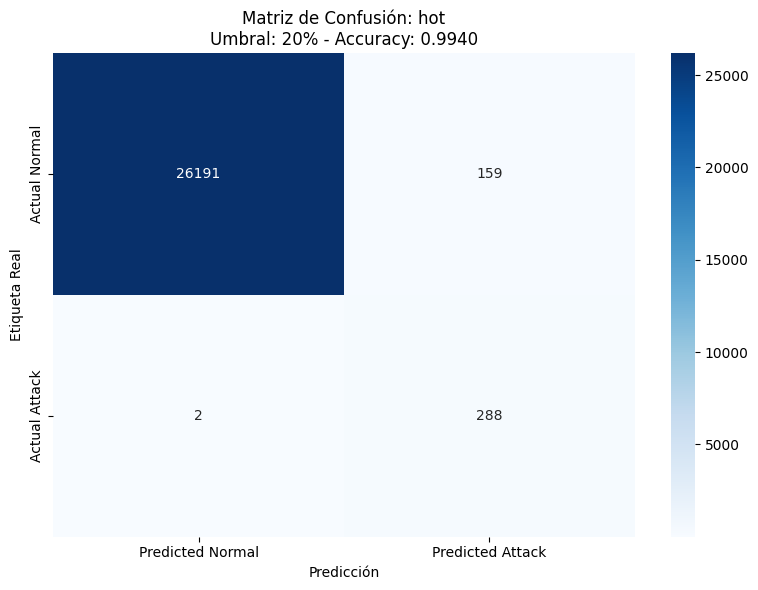


Caracteristica 2/5: dst_host_srv_rerror_rate
Parámetros del modelo: λ=18.2560, escala=0.0548
Distancia Jensen-Shannon: 0.466678
Umbrales de verosimilitud calculados: ['17.343224', '16.430423', '14.604820']

--- Umbral 1/3: 5% (likelihood ≥ 17.343224) ---
Resultados:
  - Accuracy: 0.9046
  - Precision (detección de ataques): 0.0990
  - Recall (sensibilidad): 0.9586
  - Specificity (especificidad): 0.9040
  - F1-Score: 0.1795
  - Matriz de confusión:
    TN=23821 (Normal→Normal), FP=2529 (Normal→Ataque)
    FN=12 (Ataque→Normal), TP=278 (Ataque→Ataque)


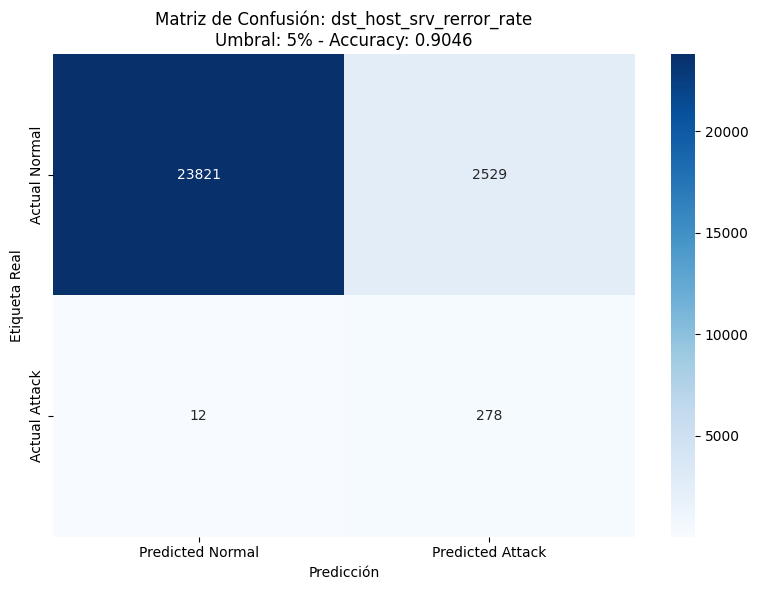


--- Umbral 2/3: 10% (likelihood ≥ 16.430423) ---
Resultados:
  - Accuracy: 0.9046
  - Precision (detección de ataques): 0.0990
  - Recall (sensibilidad): 0.9586
  - Specificity (especificidad): 0.9040
  - F1-Score: 0.1795
  - Matriz de confusión:
    TN=23821 (Normal→Normal), FP=2529 (Normal→Ataque)
    FN=12 (Ataque→Normal), TP=278 (Ataque→Ataque)


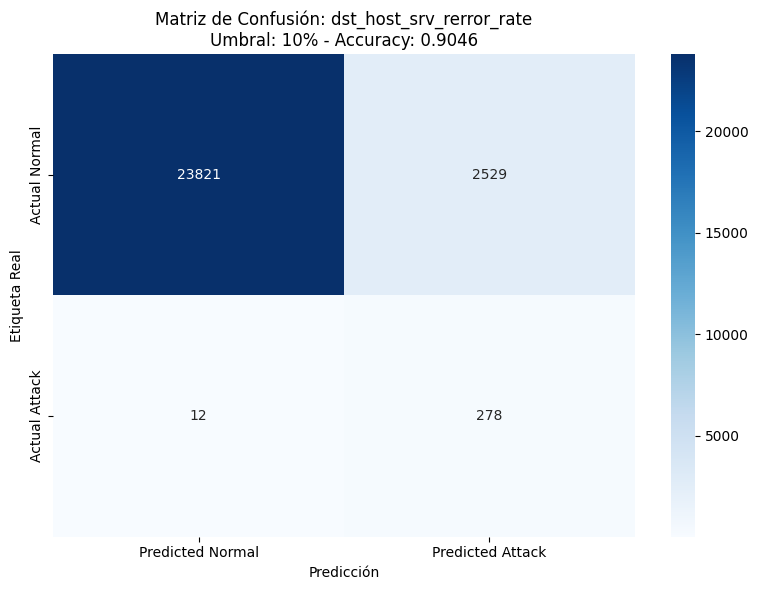


--- Umbral 3/3: 20% (likelihood ≥ 14.604820) ---
Resultados:
  - Accuracy: 0.9228
  - Precision (detección de ataques): 0.1033
  - Recall (sensibilidad): 0.7931
  - Specificity (especificidad): 0.9242
  - F1-Score: 0.1828
  - Matriz de confusión:
    TN=24353 (Normal→Normal), FP=1997 (Normal→Ataque)
    FN=60 (Ataque→Normal), TP=230 (Ataque→Ataque)


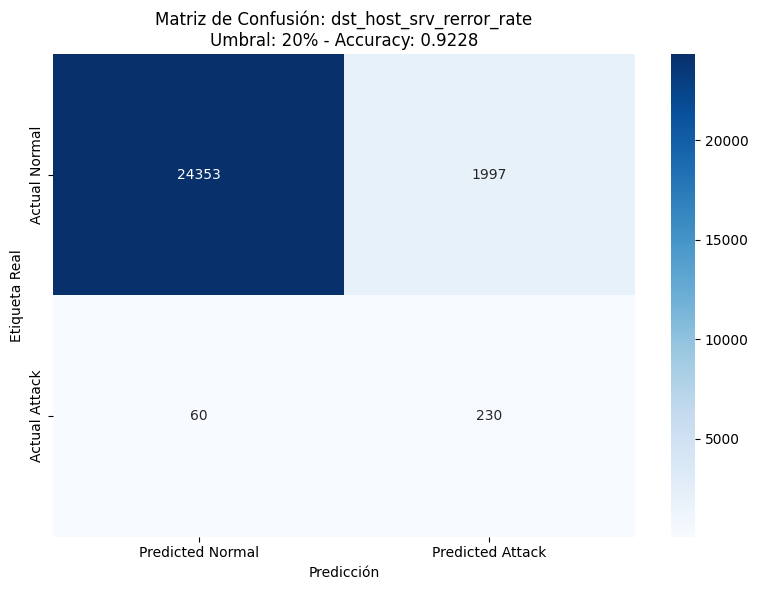


Caracteristica 3/5: dst_host_rerror_rate
Parámetros del modelo: λ=17.6171, escala=0.0568
Distancia Jensen-Shannon: 0.459732
Umbrales de verosimilitud calculados: ['16.736235', '15.855381', '14.093672']

--- Umbral 1/3: 5% (likelihood ≥ 16.736235) ---
Resultados:
  - Accuracy: 0.9041
  - Precision (detección de ataques): 0.0986
  - Recall (sensibilidad): 0.9586
  - Specificity (especificidad): 0.9035
  - F1-Score: 0.1788
  - Matriz de confusión:
    TN=23808 (Normal→Normal), FP=2542 (Normal→Ataque)
    FN=12 (Ataque→Normal), TP=278 (Ataque→Ataque)


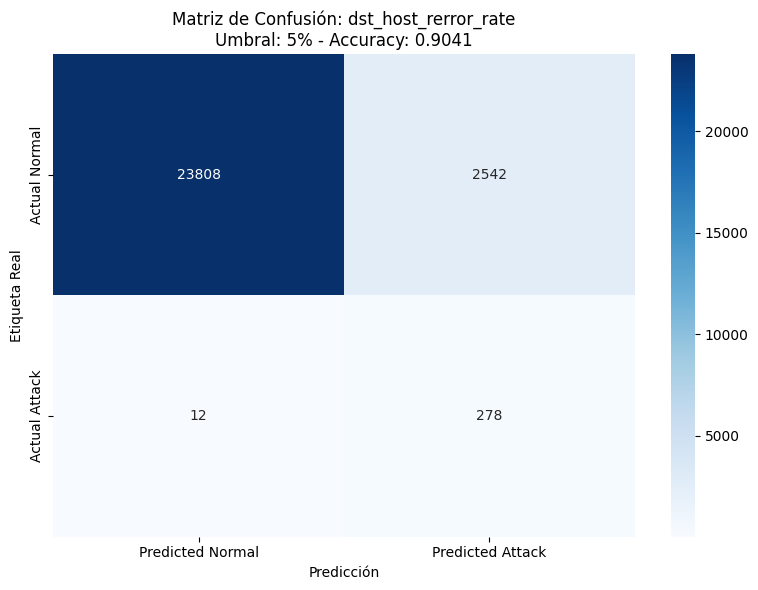


--- Umbral 2/3: 10% (likelihood ≥ 15.855381) ---
Resultados:
  - Accuracy: 0.9041
  - Precision (detección de ataques): 0.0986
  - Recall (sensibilidad): 0.9586
  - Specificity (especificidad): 0.9035
  - F1-Score: 0.1788
  - Matriz de confusión:
    TN=23808 (Normal→Normal), FP=2542 (Normal→Ataque)
    FN=12 (Ataque→Normal), TP=278 (Ataque→Ataque)


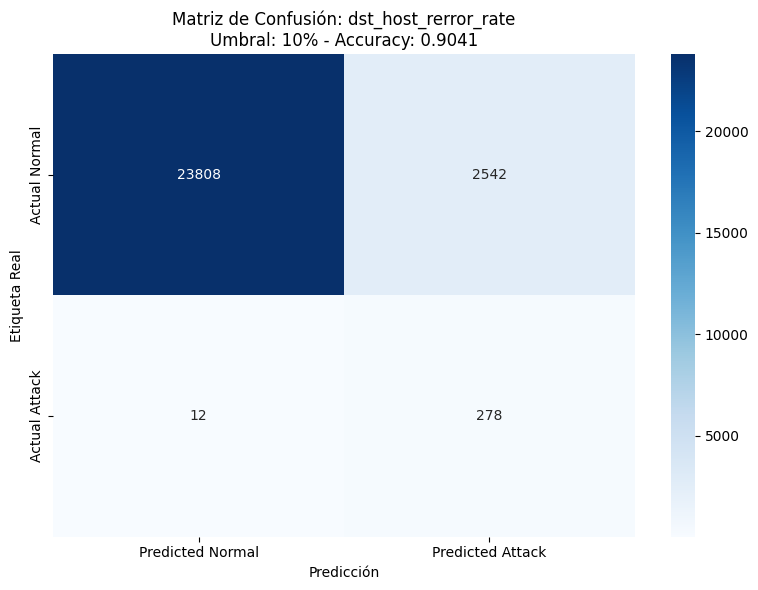


--- Umbral 3/3: 20% (likelihood ≥ 14.093672) ---
Resultados:
  - Accuracy: 0.9158
  - Precision (detección de ataques): 0.0953
  - Recall (sensibilidad): 0.7931
  - Specificity (especificidad): 0.9171
  - F1-Score: 0.1701
  - Matriz de confusión:
    TN=24166 (Normal→Normal), FP=2184 (Normal→Ataque)
    FN=60 (Ataque→Normal), TP=230 (Ataque→Ataque)


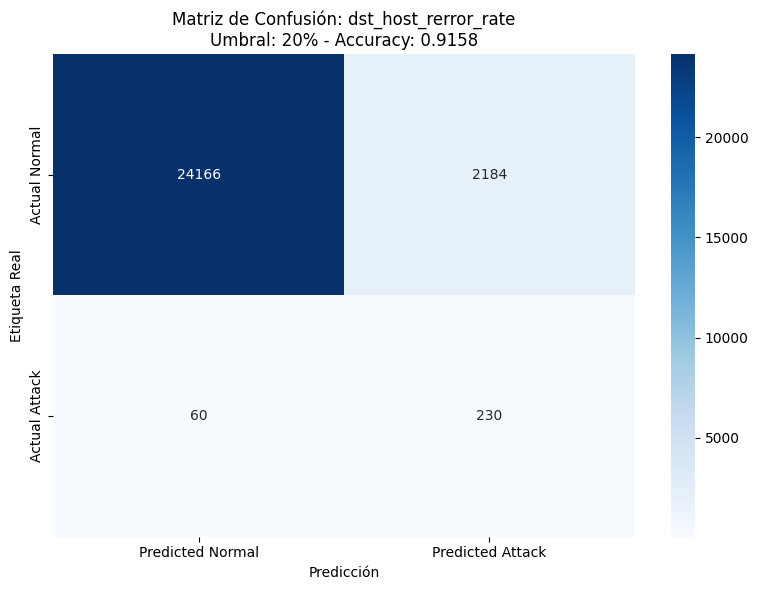


Caracteristica 4/5: srv_rerror_rate
Parámetros del modelo: λ=18.1296, escala=0.0552
Distancia Jensen-Shannon: 0.373477
Umbrales de verosimilitud calculados: ['17.223143', '16.316662', '14.503699']

--- Umbral 1/3: 5% (likelihood ≥ 17.223143) ---
Resultados:
  - Accuracy: 0.9330
  - Precision (detección de ataques): 0.0657
  - Recall (sensibilidad): 0.3897
  - Specificity (especificidad): 0.9390
  - F1-Score: 0.1124
  - Matriz de confusión:
    TN=24743 (Normal→Normal), FP=1607 (Normal→Ataque)
    FN=177 (Ataque→Normal), TP=113 (Ataque→Ataque)


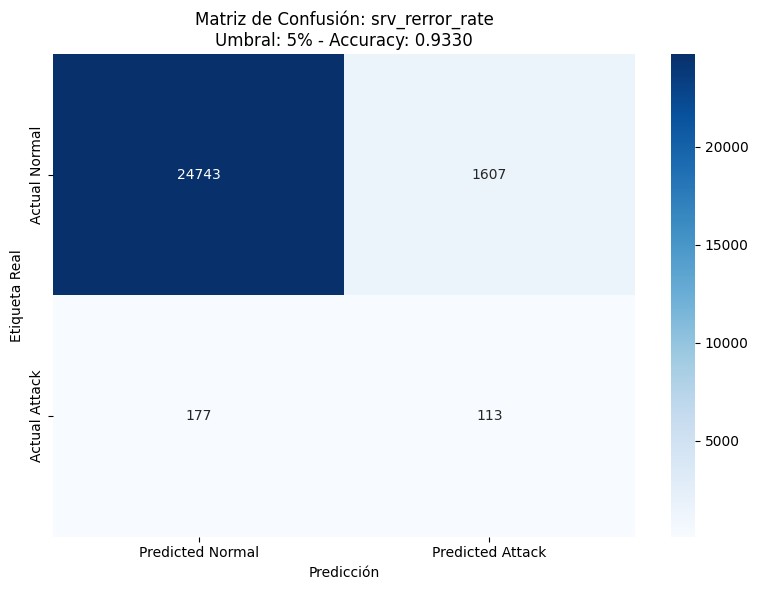


--- Umbral 2/3: 10% (likelihood ≥ 16.316662) ---
Resultados:
  - Accuracy: 0.9330
  - Precision (detección de ataques): 0.0657
  - Recall (sensibilidad): 0.3897
  - Specificity (especificidad): 0.9390
  - F1-Score: 0.1124
  - Matriz de confusión:
    TN=24743 (Normal→Normal), FP=1607 (Normal→Ataque)
    FN=177 (Ataque→Normal), TP=113 (Ataque→Ataque)


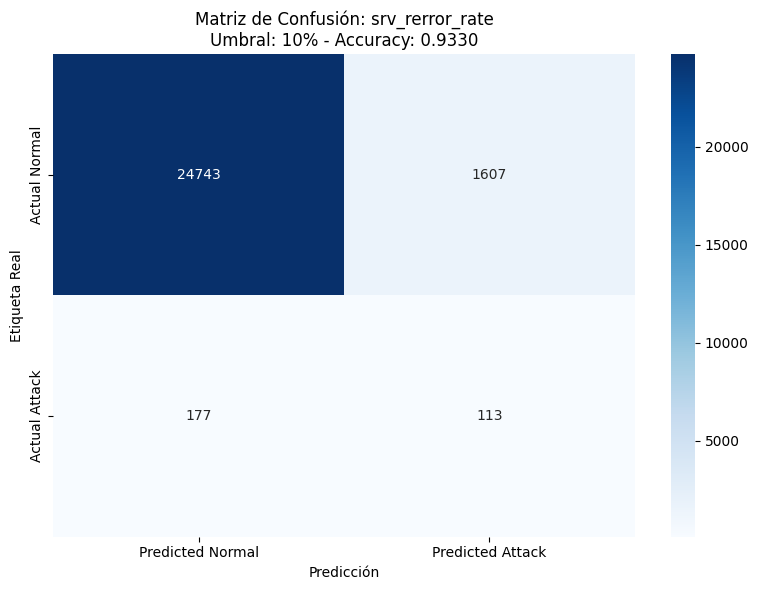


--- Umbral 3/3: 20% (likelihood ≥ 14.503699) ---
Resultados:
  - Accuracy: 0.9331
  - Precision (detección de ataques): 0.0657
  - Recall (sensibilidad): 0.3897
  - Specificity (especificidad): 0.9391
  - F1-Score: 0.1125
  - Matriz de confusión:
    TN=24744 (Normal→Normal), FP=1606 (Normal→Ataque)
    FN=177 (Ataque→Normal), TP=113 (Ataque→Ataque)


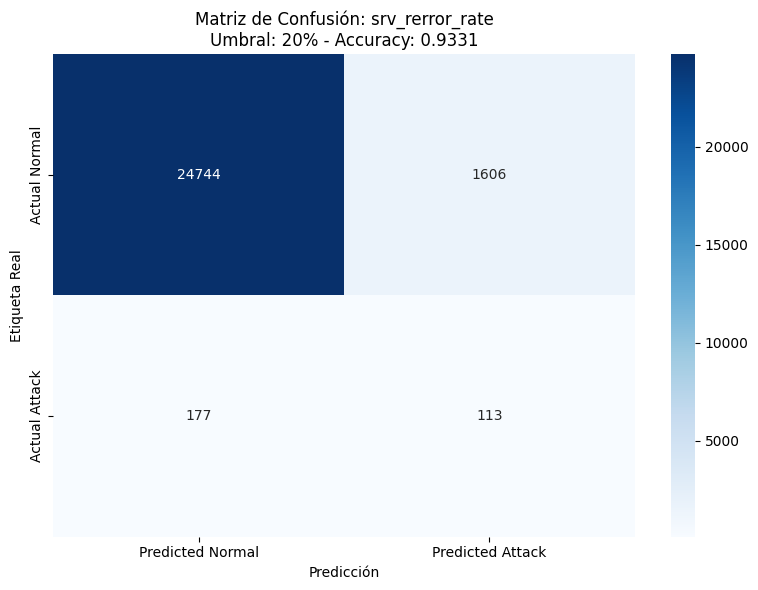


Caracteristica 5/5: service_http
Parámetros del modelo: λ=1.4432, escala=0.6929
Distancia Jensen-Shannon: 0.346864
Umbrales de verosimilitud calculados: ['1.371023', '1.298864', '1.154546']

--- Umbral 1/3: 5% (likelihood ≥ 1.371023) ---
Resultados:
  - Accuracy: 0.3138
  - Precision (detección de ataques): 0.0156
  - Recall (sensibilidad): 1.0000
  - Specificity (especificidad): 0.3062
  - F1-Score: 0.0308
  - Matriz de confusión:
    TN=8069 (Normal→Normal), FP=18281 (Normal→Ataque)
    FN=0 (Ataque→Normal), TP=290 (Ataque→Ataque)


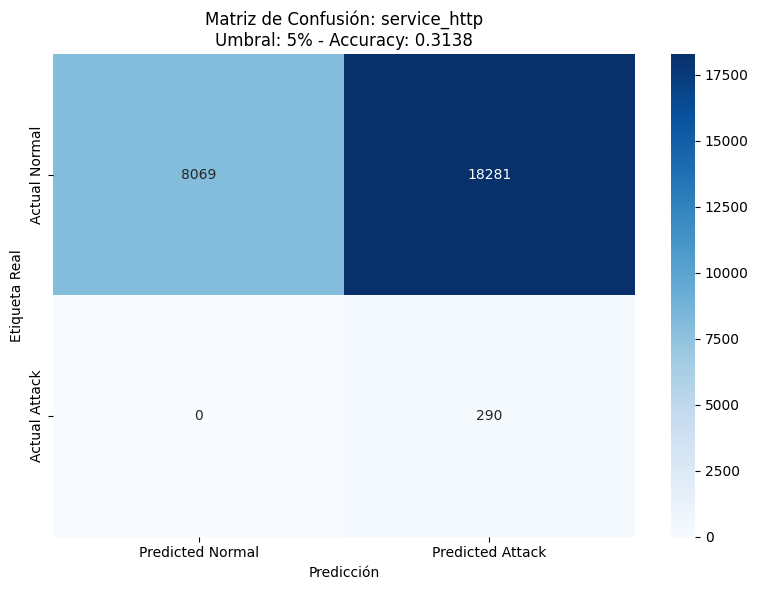


--- Umbral 2/3: 10% (likelihood ≥ 1.298864) ---
Resultados:
  - Accuracy: 0.3138
  - Precision (detección de ataques): 0.0156
  - Recall (sensibilidad): 1.0000
  - Specificity (especificidad): 0.3062
  - F1-Score: 0.0308
  - Matriz de confusión:
    TN=8069 (Normal→Normal), FP=18281 (Normal→Ataque)
    FN=0 (Ataque→Normal), TP=290 (Ataque→Ataque)


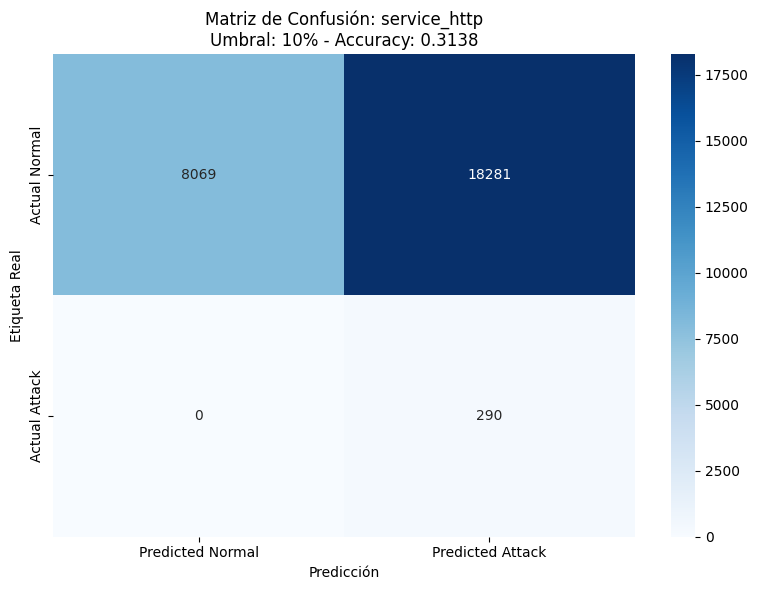


--- Umbral 3/3: 20% (likelihood ≥ 1.154546) ---
Resultados:
  - Accuracy: 0.3138
  - Precision (detección de ataques): 0.0156
  - Recall (sensibilidad): 1.0000
  - Specificity (especificidad): 0.3062
  - F1-Score: 0.0308
  - Matriz de confusión:
    TN=8069 (Normal→Normal), FP=18281 (Normal→Ataque)
    FN=0 (Ataque→Normal), TP=290 (Ataque→Ataque)


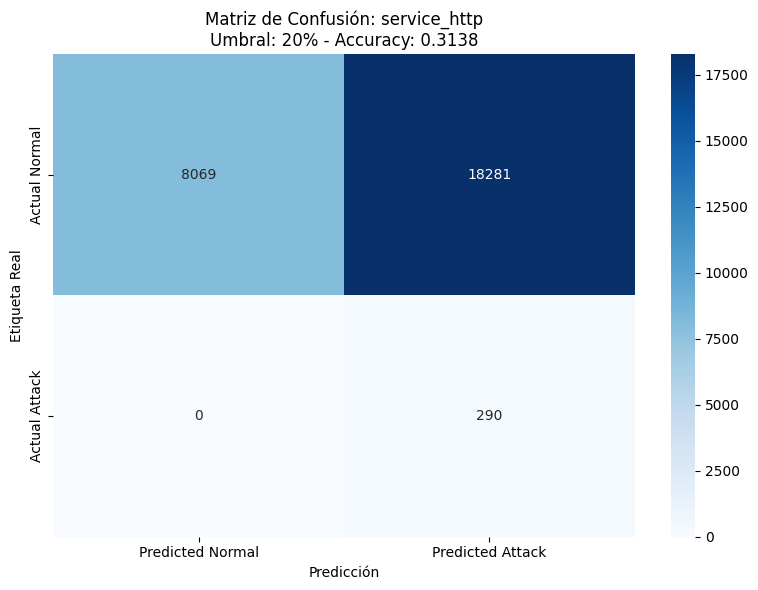

In [14]:
# Definir los 3 umbrales de aceptación (percentiles de la distribución)
thresholds_percentiles = [5, 10, 20]
print(f"\nUmbrales basados en percentiles de la distribución exponencial: {thresholds_percentiles}%")

classification_results = {}


def calculate_likelihood_and_classify(data, loc, scale, threshold_value):
    """
    Calcular verosimilitud y clasificar usando el umbral especificado.

    Parametros
    ----------
    data : Datos de prueba para calcular la verosimilitud.
    loc : Parámetro de localización de la distribución exponencial.
    scale : Parámetro de escala de la distribución exponencial.
    threshold_value : Umbral de verosimilitud para clasificar.

    Retorna
    -------
    likelihood : Verosimilitud calculada para cada punto de datos.
    predictions : Clasificaciones ('normal.' o 'back.') basadas en el umbral.
    """
    # Aplicar transformación si es necesaria (igual que en entrenamiento)
    if loc > 0:
        data_transformed = data - loc
    else:
        data_transformed = data.copy()

    # Asegurar valores no negativos
    data_transformed = np.maximum(data_transformed, 1e-10)

    # Calcular log-verosimilitud
    log_likelihood = stats.expon.logpdf(data_transformed, loc=0, scale=scale)

    # Convertir a verosimilitud
    likelihood = np.exp(log_likelihood)

    # Clasificar: si likelihood >= threshold → Normal, sino → Ataque
    predictions = np.where(likelihood >= threshold_value, 'normal.', 'back.')

    return likelihood, predictions


def plot_confusion_matrix(cm, feature_name, threshold_perc, accuracy):
    """Función para plotear matriz de confusión"""
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Normal', 'Predicted Attack'],
                yticklabels=['Actual Normal', 'Actual Attack'])
    plt.title(f'Matriz de Confusión: {feature_name}\nUmbral: {threshold_perc}% - Accuracy: {accuracy:.4f}')
    plt.ylabel('Etiqueta Real')
    plt.xlabel('Predicción')
    plt.tight_layout()
    plt.show()


# Procesar cada característica con cada umbral
for i, feature in enumerate(top_5_features, 1):
    print(f"\n{'=' * 60}")
    print(f"Caracteristica {i}/5: {feature}")
    print(f"{'=' * 60}")

    # Obtener parámetros del modelo ajustado
    lambda_param = exponential_params_top5[feature]['lambda']
    scale = exponential_params_top5[feature]['scale']
    loc = exponential_params_top5[feature]['loc']
    js_distance = exponential_params_top5[feature]['jensen_shannon']

    print(f"Parámetros del modelo: λ={lambda_param:.4f}, escala={scale:.4f}")
    print(f"Distancia Jensen-Shannon: {js_distance:.6f}")

    # Obtener datos de prueba para esta característica
    test_data = X_test[feature].values
    test_data_clean = test_data[~np.isnan(test_data)]
    y_test_clean = y_test[~np.isnan(test_data)]

    # Calcular umbrales basados en percentiles de la distribución
    thresholds_values = []
    for perc in thresholds_percentiles:
        # Umbral como percentil de la distribución exponencial
        threshold_val = stats.expon.ppf(perc / 100, loc=loc, scale=scale)
        # Convertir a likelihood
        threshold_likelihood = stats.expon.pdf(threshold_val, loc=loc, scale=scale)
        thresholds_values.append(threshold_likelihood)

    print(f"Umbrales de verosimilitud calculados: {[f'{t:.6f}' for t in thresholds_values]}")

    classification_results[feature] = {}

    # Evaluar con cada umbral
    for j, (threshold_perc, threshold_val) in enumerate(zip(thresholds_percentiles, thresholds_values), 1):
        print(f"\n--- Umbral {j}/3: {threshold_perc}% (likelihood ≥ {threshold_val:.6f}) ---")

        # Calcular verosimilitud y clasificar
        likelihoods, predictions = calculate_likelihood_and_classify(
            test_data_clean, loc, scale, threshold_val
        )

        # Calcular métricas
        accuracy = accuracy_score(y_test_clean, predictions)
        cm = confusion_matrix(y_test_clean, predictions, labels=['normal.', 'back.'])

        # Calcular métricas adicionales
        tn, fp, fn, tp = cm.ravel()
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        # Almacenar resultados
        classification_results[feature][f'threshold_{threshold_perc}%'] = {
            'threshold_value': threshold_val,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'specificity': specificity,
            'f1_score': f1_score,
            'confusion_matrix': cm,
            'predictions': predictions,
            'likelihoods': likelihoods
        }

        print(f"Resultados:")
        print(f"  - Accuracy: {accuracy:.4f}")
        print(f"  - Precision (detección de ataques): {precision:.4f}")
        print(f"  - Recall (sensibilidad): {recall:.4f}")
        print(f"  - Specificity (especificidad): {specificity:.4f}")
        print(f"  - F1-Score: {f1_score:.4f}")
        print(f"  - Matriz de confusión:")
        print(f"    TN={tn} (Normal→Normal), FP={fp} (Normal→Ataque)")
        print(f"    FN={fn} (Ataque→Normal), TP={tp} (Ataque→Ataque)")

        # Graficar matriz de confusión
        plot_confusion_matrix(cm, feature, threshold_perc, accuracy)

=== Tabla resumen comparativa ===
Tabla completa de resultados:


,Característica,Jensen-Shannon,Umbral,Accuracy,Precision,Recall,Specificity,F1-Score
0,hot,0.8132,threshold_5%,0.9940,0.6443,0.9931,0.9940,0.7815
1,hot,0.8132,threshold_10%,0.9940,0.6443,0.9931,0.9940,0.7815
2,hot,0.8132,threshold_20%,0.9940,0.6443,0.9931,0.9940,0.7815
3,dst_host_srv_rerror_rate,0.4667,threshold_5%,0.9046,0.0990,0.9586,0.9040,0.1795
4,dst_host_srv_rerror_rate,0.4667,threshold_10%,0.9046,0.0990,0.9586,0.9040,0.1795
5,dst_host_srv_rerror_rate,0.4667,threshold_20%,0.9228,0.1033,0.7931,0.9242,0.1828
6,dst_host_rerror_rate,0.4597,threshold_5%,0.9041,0.0986,0.9586,0.9035,0.1788
7,dst_host_rerror_rate,0.4597,threshold_10%,0.9041,0.0986,0.9586,0.9035,0.1788
8,dst_host_rerror_rate,0.4597,threshold_20%,0.9158,0.0953,0.7931,0.9171,0.1701
9,srv_rerror_rate,0.3735,threshold_5%,0.9330,0.0657,0.3897,0.9390,0.1124



=== Analisis de mejor rendimiento ===
Mejor Accuracy: 0.9940
  - Característica: hot
  - Umbral: threshold_5%
Mejor F1-Score: 0.7815
  - Característica: hot
  - Umbral: threshold_5%
Mejor Balance (Precision+Recall)/2: 0.8187
  - Característica: hot
  - Umbral: threshold_5%


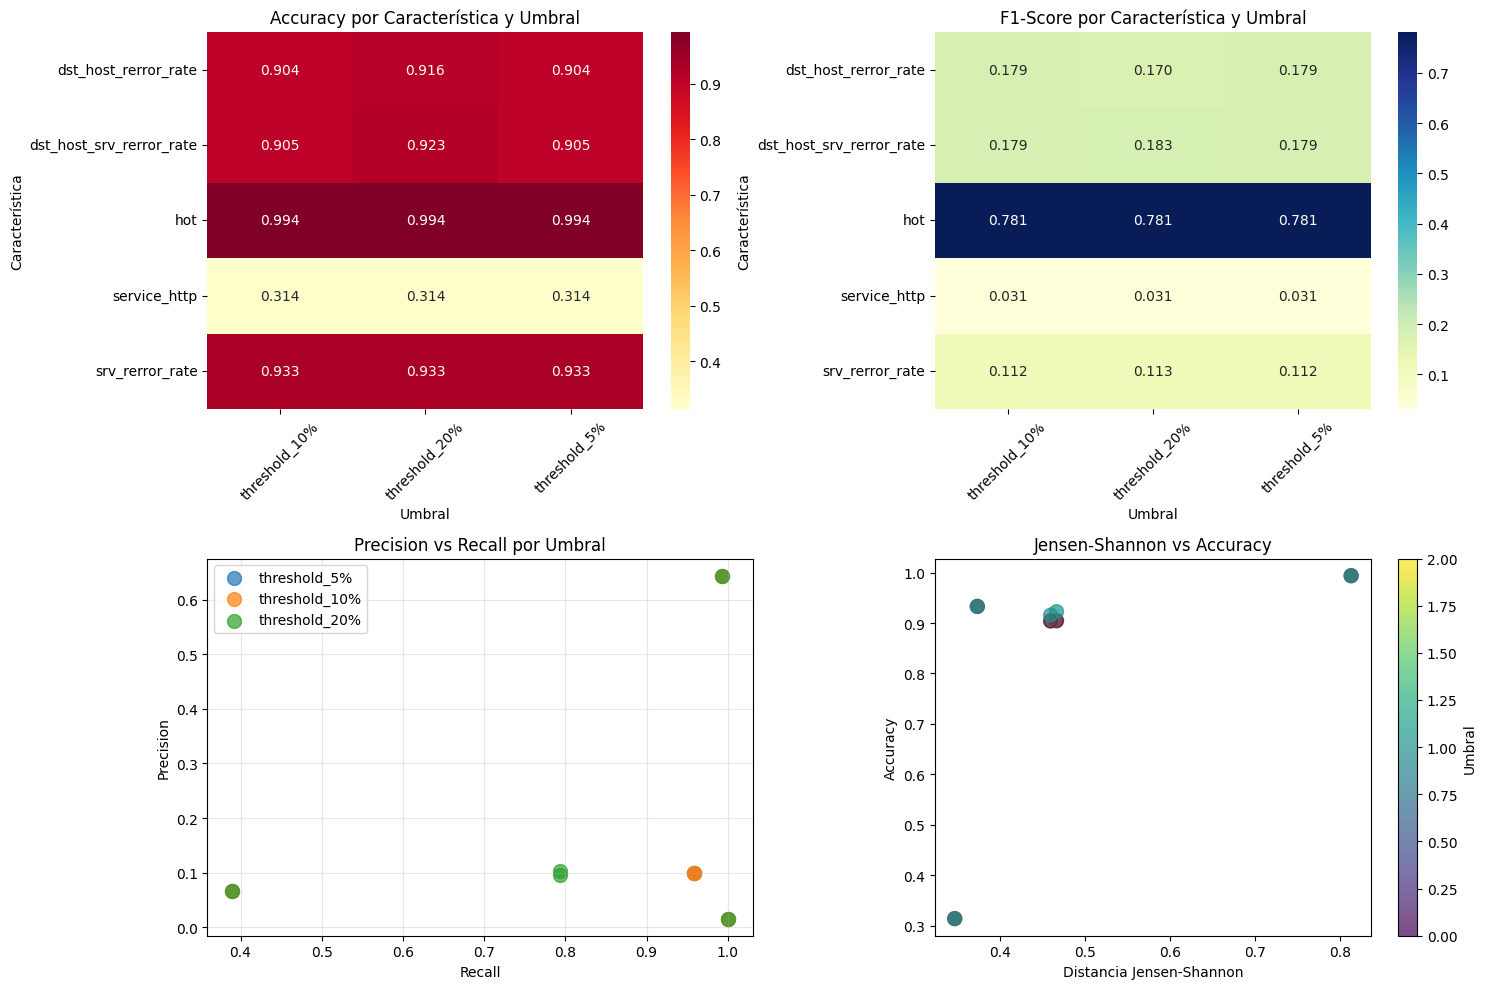

In [15]:
print("=== Tabla resumen comparativa ===")

summary_data = []
for feature in top_5_features:
    js_dist = exponential_params_top5[feature]['jensen_shannon']
    for threshold_key, results in classification_results[feature].items():
        summary_data.append({
            'Característica': feature,
            'Jensen-Shannon': js_dist,
            'Umbral': threshold_key,
            'Accuracy': results['accuracy'],
            'Precision': results['precision'],
            'Recall': results['recall'],
            'Specificity': results['specificity'],
            'F1-Score': results['f1_score']
        })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.round(4)

print("Tabla completa de resultados:")
display_dataframe_completely(summary_df)

print(f"\n=== Analisis de mejor rendimiento ===")

# Mejor accuracy
best_accuracy = summary_df.loc[summary_df['Accuracy'].idxmax()]
print(f"Mejor Accuracy: {best_accuracy['Accuracy']:.4f}")
print(f"  - Característica: {best_accuracy['Característica']}")
print(f"  - Umbral: {best_accuracy['Umbral']}")

# Mejor F1-Score
best_f1 = summary_df.loc[summary_df['F1-Score'].idxmax()]
print(f"Mejor F1-Score: {best_f1['F1-Score']:.4f}")
print(f"  - Característica: {best_f1['Característica']}")
print(f"  - Umbral: {best_f1['Umbral']}")

# Mejor balance (Precision + Recall)
summary_df['Balance'] = (summary_df['Precision'] + summary_df['Recall']) / 2
best_balance = summary_df.loc[summary_df['Balance'].idxmax()]
print(f"Mejor Balance (Precision+Recall)/2: {best_balance['Balance']:.4f}")
print(f"  - Característica: {best_balance['Característica']}")
print(f"  - Umbral: {best_balance['Umbral']}")

# Gráfico comparativo
plt.figure(figsize=(15, 10))

# Subplot 1: Accuracy por característica y umbral
plt.subplot(2, 2, 1)
summary_pivot = summary_df.pivot(index='Característica', columns='Umbral', values='Accuracy')
sns.heatmap(summary_pivot, annot=True, cmap='YlOrRd', fmt='.3f')
plt.title('Accuracy por Característica y Umbral')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Subplot 2: F1-Score
plt.subplot(2, 2, 2)
summary_pivot_f1 = summary_df.pivot(index='Característica', columns='Umbral', values='F1-Score')
sns.heatmap(summary_pivot_f1, annot=True, cmap='YlGnBu', fmt='.3f')
plt.title('F1-Score por Característica y Umbral')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Subplot 3: Precision vs Recall
plt.subplot(2, 2, 3)
for threshold in summary_df['Umbral'].unique():
    subset = summary_df[summary_df['Umbral'] == threshold]
    plt.scatter(subset['Recall'], subset['Precision'],
                label=threshold, s=100, alpha=0.7)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision vs Recall por Umbral')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 4: Jensen-Shannon vs Accuracy
plt.subplot(2, 2, 4)
plt.scatter(summary_df['Jensen-Shannon'], summary_df['Accuracy'],
            c=summary_df['Umbral'].astype('category').cat.codes,
            cmap='viridis', s=100, alpha=0.7)
plt.xlabel('Distancia Jensen-Shannon')
plt.ylabel('Accuracy')
plt.title('Jensen-Shannon vs Accuracy')
plt.colorbar(label='Umbral')

plt.tight_layout()
plt.show()

## Explicación del codigo

De esta seccion cuatro se realizó una logica en la cual se definieron tres umbrales en el orden de 5%, 10% y 20%, después se definio la función `calculate_likelihood_and_classify` la cual calcula la verosimilitud por medio de la función de scipy `stats.expon.logpdf` para calcular la log-verosimilitud y después se convierte a verosimilitud usando la funcion de numpy `np.exp`, la logica de esta funcion es que si la verosimilitud es mayor o igual al umbral se clasifica como una prediccion de tráfico normal y si no de ataque.

En sí la logica principal itera por la salida de las cinco mejores caracteristicas y se obtienen los parametros de los resultados de la parte 3 donde se pueden reutilizar los valores de `lambda`, `scale`, `loc` y `jensen_shannon` para cada caracteristica, además se obtienen los datos de la particion de prueba para la evaluacion. Se calculan los umbrales adaptativos en el cual se itera por los umbrales escogidos y se calcula el umbral como percentil de la distribucion exponencial por medio de `stats.expon.ppf` y se convierte finalmente a verosimilitud nuevamente por medio de la misma funcion.

Finalmente, se calculan las metricas por cada umbral, se utiliza la funcion `calculate_likelihood_and_classify` para calcular la verosimilitud y la prediccion del tráfico, se recopila el accuracy, matriz de confusion y las metricas de precision, recall, specificity y el F1-Score para almacenarlos en una variable por cada umbral y caracteristica, generando como salida los resultados del umbral y caracteristica, asi como un plot de la matriz de confusion.

Como resumen también se generó una tabla con todos los datos por caracteristica y umbral para comparacion, analisis de mejor accuracy, f1-score y balance, y unos graficos comparativos de las metricas recopiladas.

## Interpretación de Resultados

Se definieron tres umbrales 5%, 10% y 20%, estos son usados en conjunto con la verosimilitud para calcular si se pertenece a tráfico normal o de ataque, si es mayor o igual al umbral es tráfico normal y si es menor es tráfico de ataque.

Se utiliza la verosimilitud para indicar que tan "normal" es ese valor, por ejemplo si es un valor alto significa que es un valor tipico para el tráfico normal indicando que probablemente sea tráfico normal, si es bajo significa que es un valor raro de ver en el tráfico normal y podria significar tráfico.

En conjunto, los umbrales y la verosimilitud me indican si la verosimilitud calculada para una caracteristica es indicativa de tráfico normal o de ataque respecto al umbral.

En cuanto a los umbrales, se utilizan percentiles relativamente bajos de 5%, 10% y 20%, ya que los ataques son eventos poco comunes, lo cual es acorde al dataset donde el tráfico normal representa el 98.9% y los ataques solo el 1.1%. El umbral del 5% es el más conservador, establece un punto muy estricto, clasificando como ataques únicamente aquellas conexiones con verosimilitudes extremadamente bajas, esto minimiza las falsas alarmas, pero puede perder ataques sutiles. El umbral del 10% representa un balance entre sensibilidad y especificidad, siendo apropiado para uso general. El umbral del 20% es el más permisivo, usa un punto de corte más bajo, detectando como ataques incluso conexiones con verosimilitudes moderadamente bajas, esto maximiza la detección de ataques reales al costo de generar más falsas alarmas.

La caracteristica `hot` fue la que obtuvo un mejor rendimiento, ya que en los tres umbrales generó los mismos resultados, obteniendo un accuracy de 0.9940, precision de 0.6443, recall de 0.9931 y F1-Score de 0.7815, estas metricas fueron las más altas de todas las caracteristicas, inclusive en el caso de la matriz de confusion se clasificó correctamente el 99.31% de los ataques reales y solo un 1.1% de falsos positivos, generando un buen resultado y demostrando que es una caracteristica que logra separar correctamente las clases.

Los siguientes resultados fueron los de las caracteristicas `dst_host_srv_rerror_rate`, `dst_host_rerror_rate`, `srv_rerror_rate`, estas presentan resultados similares que presentan un buen accuracy entre 0.90 y 0.93, además de un recall bueno en su mayoria de 0.7 a 0.9, excepto en el valor srv_rerror_rate que tiene una precision de 0.3. Otro punto negativo en estas caracteristicas es el F1-Score que presenta un valor de 0.11 a 0.17. Estas metricas indican que tienen una alta tasa de falsos positivos al tener una precision baja y podrian clasificar incorrectamente las clases. En el caso de los umbrales para estas caracteristicas el valor de 5% y 10% tienen valores iguales, excepto el 20% que si mejora las metricas un poco.

En comparacion con `hot`, `dst_host_srv_rerror_rate`, `dst_host_rerror_rate` y `srv_rerror_rate` presentan un alza en los falsos positivos y falsos negativos, en el caso de `dst_host_srv_rerror_rate` se encuentra en su mejor umbral de 20% alrededor de 1997 falsos positivos y 60 falsos negativos, para `dst_host_rerror_rate` se encontro alrededor de 2184 falsos positivos y 60 falsos negativos en su 20% de umbral, y para `srv_rerror_rate` se encontró en su mejor umbral de 20% un total de falsos positivos de 1606 y falsos negativos de 177. En comparacion `hot` tuvo 159 falsos positivos y 2 falsos negativos, siendo una diferencia muy visible respecto a las demás caracteristicas.

La peor caracteristica en este analisis fue la de `service_http` que obtuvo los mismos valores en todos los umbrales con un accuracy de 0.3138, precision de 0.0156, recall de 1 y F1-Score de 0.0308 con un total de 18281 falsos positivos y 0 falsos negativos, esto apoya la puntuacion baja de Jensen Shannon que tenía esta caracteristica y demuestra lo limitada que es la separacion de clases entre las distribuciones de tráfico normal y de ataque.

# Parte 5

Realice lo mismo del item anterior, pero usando como puntaje el promedio de las verosimilitudes
de las 5 caracteristicas. Calcule la matriz de confusion. Comente los resultados.

=== Clasificación usando promedio de verosimilitudes (5 características) ===
Datos de prueba limpios: 26640 muestras
Distribución de clases en prueba: {'normal.': 26350, 'back.': 290}
Calculando verosimilitudes individuales...
  1. hot: verosimilitud promedio = 20.49826823
  2. dst_host_srv_rerror_rate: verosimilitud promedio = 16.88174371
  3. dst_host_rerror_rate: verosimilitud promedio = 16.22874661
  4. srv_rerror_rate: verosimilitud promedio = 16.99744490
  5. service_http: verosimilitud promedio = 0.67473132

Estadísticas de puntajes combinados:
  - Promedio: 14.25618695
  - Mediana: 15.03833336
  - Desv. estándar: 2.67915693
  - Rango: [0.06816889, 15.25880106]

=== Definicion de umbrales para puntajes combinados ===
Umbral 5%: 4.23809649
Umbral 10%: 12.92946042
Umbral 20%: 15.03833336

=== Evaluacion con diferentes umbrales ===

--- UMBRAL 1/3: 5% (puntaje ≥ 4.23809649) ---
Resultados:
  - Accuracy: 0.9467
  - Precision (detección de ataques): 0.0758
  - Recall (sensibilidad): 

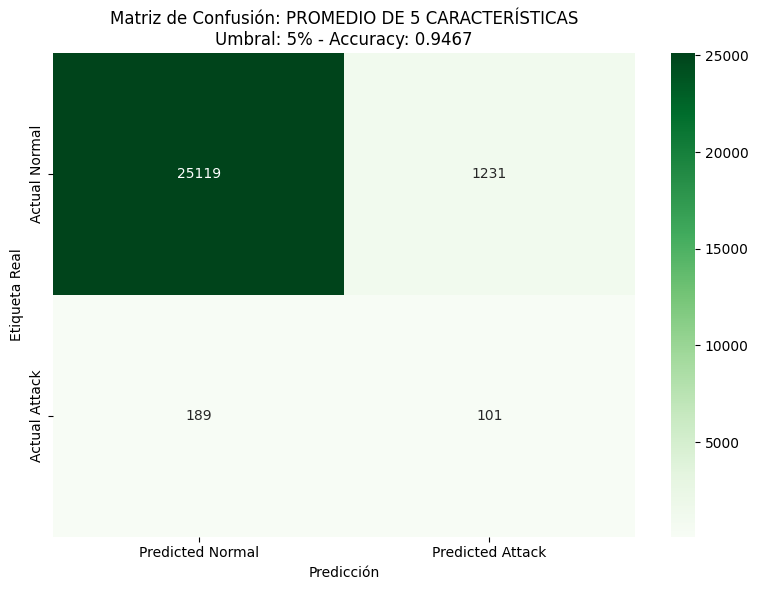


--- UMBRAL 2/3: 10% (puntaje ≥ 12.92946042) ---
Resultados:
  - Accuracy: 0.9110
  - Precision (detección de ataques): 0.1090
  - Recall (sensibilidad): 1.0000
  - Specificity (especificidad): 0.9101
  - F1-Score: 0.1966
  - Matriz de confusión:
    TN=23980 (Normal→Normal), FP=2370 (Normal→Ataque)
    FN=0 (Ataque→Normal), TP=290 (Ataque→Ataque)


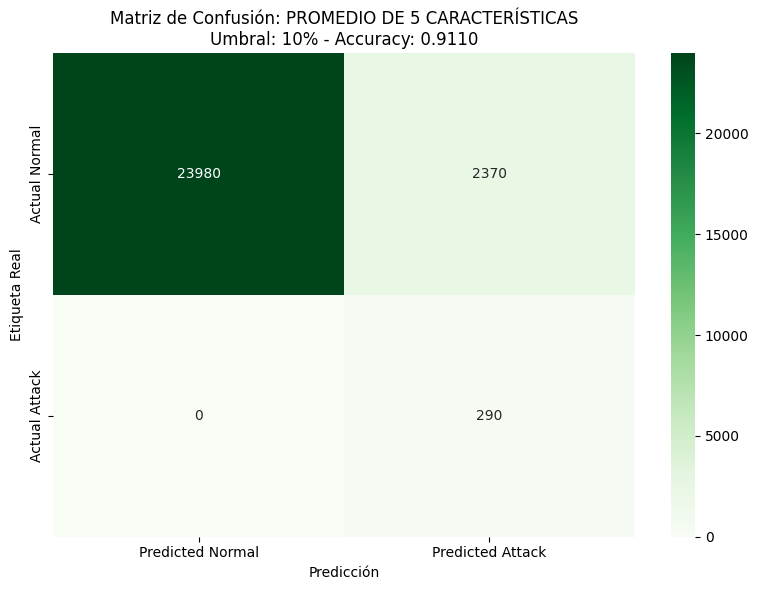


--- UMBRAL 3/3: 20% (puntaje ≥ 15.03833336) ---
Resultados:
  - Accuracy: 0.8782
  - Precision (detección de ataques): 0.0820
  - Recall (sensibilidad): 1.0000
  - Specificity (especificidad): 0.8769
  - F1-Score: 0.1516
  - Matriz de confusión:
    TN=23105 (Normal→Normal), FP=3245 (Normal→Ataque)
    FN=0 (Ataque→Normal), TP=290 (Ataque→Ataque)


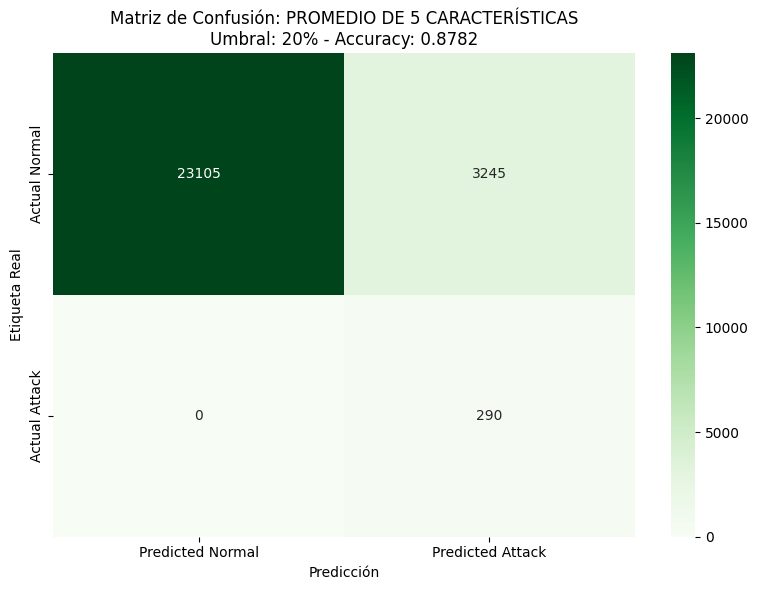

In [16]:
print("=== Clasificación usando promedio de verosimilitudes (5 características) ===")


def calculate_combined_likelihood_scores(test_data_dict, exponential_params):
    """
    Calcular el promedio de verosimilitudes para las 5 características

    Parametros
    ----------
    test_data_dict : Diccionario con datos de prueba para cada característica.
    exponential_params : Diccionario con parámetros del modelo exponencial para cada característica.

    Retorna
    -------
    combined_scores : Puntajes combinados (promedio de verosimilitudes) para cada
                        muestra en los datos de prueba.
    """
    n_samples = len(next(iter(test_data_dict.values())))
    combined_scores = np.zeros(n_samples)

    print("Calculando verosimilitudes individuales...")
    for i, feature in enumerate(top_5_features):
        # Obtener parámetros del modelo
        scale = exponential_params[feature]['scale']
        loc = exponential_params[feature]['loc']

        # Obtener datos de prueba
        data = test_data_dict[feature]

        # Aplicar transformación si es necesaria
        if loc > 0:
            data_transformed = data - loc
        else:
            data_transformed = data.copy()

        # Asegurar valores no negativos
        data_transformed = np.maximum(data_transformed, 1e-10)

        # Calcular verosimilitud
        likelihood = stats.expon.pdf(data_transformed, loc=0, scale=scale)

        # Agregar al promedio (evitar valores infinitos)
        likelihood = np.clip(likelihood, 1e-15, 1e15)
        combined_scores += likelihood

        print(f"  {i + 1}. {feature}: verosimilitud promedio = {np.mean(likelihood):.8f}")

    # Promediar las verosimilitudes
    combined_scores = combined_scores / len(top_5_features)

    return combined_scores


# Preparar datos de prueba para las 5 características
test_data_dict = {}
valid_indices = None

for feature in top_5_features:
    test_data = X_test[feature].values

    # Encontrar índices válidos (sin NaN) comunes a todas las características
    if valid_indices is None:
        valid_indices = ~np.isnan(test_data)
    else:
        valid_indices = valid_indices & ~np.isnan(test_data)

    test_data_dict[feature] = test_data

# Aplicar índices válidos
for feature in top_5_features:
    test_data_dict[feature] = test_data_dict[feature][valid_indices]

y_test_clean = y_test[valid_indices]

print(f"Datos de prueba limpios: {len(y_test_clean)} muestras")
print(f"Distribución de clases en prueba: {pd.Series(y_test_clean).value_counts().to_dict()}")

# Calcular puntajes combinados
combined_likelihood_scores = calculate_combined_likelihood_scores(test_data_dict, exponential_params_top5)

print(f"\nEstadísticas de puntajes combinados:")
print(f"  - Promedio: {np.mean(combined_likelihood_scores):.8f}")
print(f"  - Mediana: {np.median(combined_likelihood_scores):.8f}")
print(f"  - Desv. estándar: {np.std(combined_likelihood_scores):.8f}")
print(f"  - Rango: [{np.min(combined_likelihood_scores):.8f}, {np.max(combined_likelihood_scores):.8f}]")

# Definir umbrales basados en percentiles de los puntajes combinados
print(f"\n=== Definicion de umbrales para puntajes combinados ===")
threshold_percentiles = [5, 10, 20]
combined_thresholds = []

for perc in threshold_percentiles:
    threshold_val = np.percentile(combined_likelihood_scores, perc)
    combined_thresholds.append(threshold_val)
    print(f"Umbral {perc}%: {threshold_val:.8f}")

# Evaluar con cada umbral
combined_results = {}

print(f"\n=== Evaluacion con diferentes umbrales ===")
for i, (threshold_perc, threshold_val) in enumerate(zip(threshold_percentiles, combined_thresholds), 1):
    print(f"\n--- UMBRAL {i}/3: {threshold_perc}% (puntaje ≥ {threshold_val:.8f}) ---")

    # Clasificar basado en el umbral
    predictions_combined = np.where(combined_likelihood_scores >= threshold_val, 'normal.', 'back.')

    # Calcular métricas
    accuracy = accuracy_score(y_test_clean, predictions_combined)
    cm = confusion_matrix(y_test_clean, predictions_combined, labels=['normal.', 'back.'])

    # Métricas detalladas
    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Almacenar resultados
    combined_results[f'threshold_{threshold_perc}%'] = {
        'threshold_value': threshold_val,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'specificity': specificity,
        'f1_score': f1_score,
        'confusion_matrix': cm,
        'predictions': predictions_combined
    }

    print(f"Resultados:")
    print(f"  - Accuracy: {accuracy:.4f}")
    print(f"  - Precision (detección de ataques): {precision:.4f}")
    print(f"  - Recall (sensibilidad): {recall:.4f}")
    print(f"  - Specificity (especificidad): {specificity:.4f}")
    print(f"  - F1-Score: {f1_score:.4f}")
    print(f"  - Matriz de confusión:")
    print(f"    TN={tn} (Normal→Normal), FP={fp} (Normal→Ataque)")
    print(f"    FN={fn} (Ataque→Normal), TP={tp} (Ataque→Ataque)")

    # Graficar matriz de confusión
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=['Predicted Normal', 'Predicted Attack'],
                yticklabels=['Actual Normal', 'Actual Attack'])
    plt.title(
        f'Matriz de Confusión: PROMEDIO DE 5 CARACTERÍSTICAS\nUmbral: {threshold_perc}% - Accuracy: {accuracy:.4f}')
    plt.ylabel('Etiqueta Real')
    plt.xlabel('Predicción')
    plt.tight_layout()
    plt.show()


Comparación: individual vs promedio combinado
Tabla comparativa:


,Método,Umbral,Accuracy,Precision,Recall,F1-Score
0,PROMEDIO_5_CARACTERÍSTICAS,threshold_5%,0.9467,0.0758,0.3483,0.1245
1,PROMEDIO_5_CARACTERÍSTICAS,threshold_10%,0.9110,0.1090,1.0000,0.1966
2,PROMEDIO_5_CARACTERÍSTICAS,threshold_20%,0.8782,0.0820,1.0000,0.1516
3,MEJOR_INDIVIDUAL_hot,threshold_5%,0.9940,0.6443,0.9931,0.7815
4,MEJOR_INDIVIDUAL_hot,threshold_10%,0.9940,0.6443,0.9931,0.7815
5,MEJOR_INDIVIDUAL_hot,threshold_20%,0.9940,0.6443,0.9931,0.7815


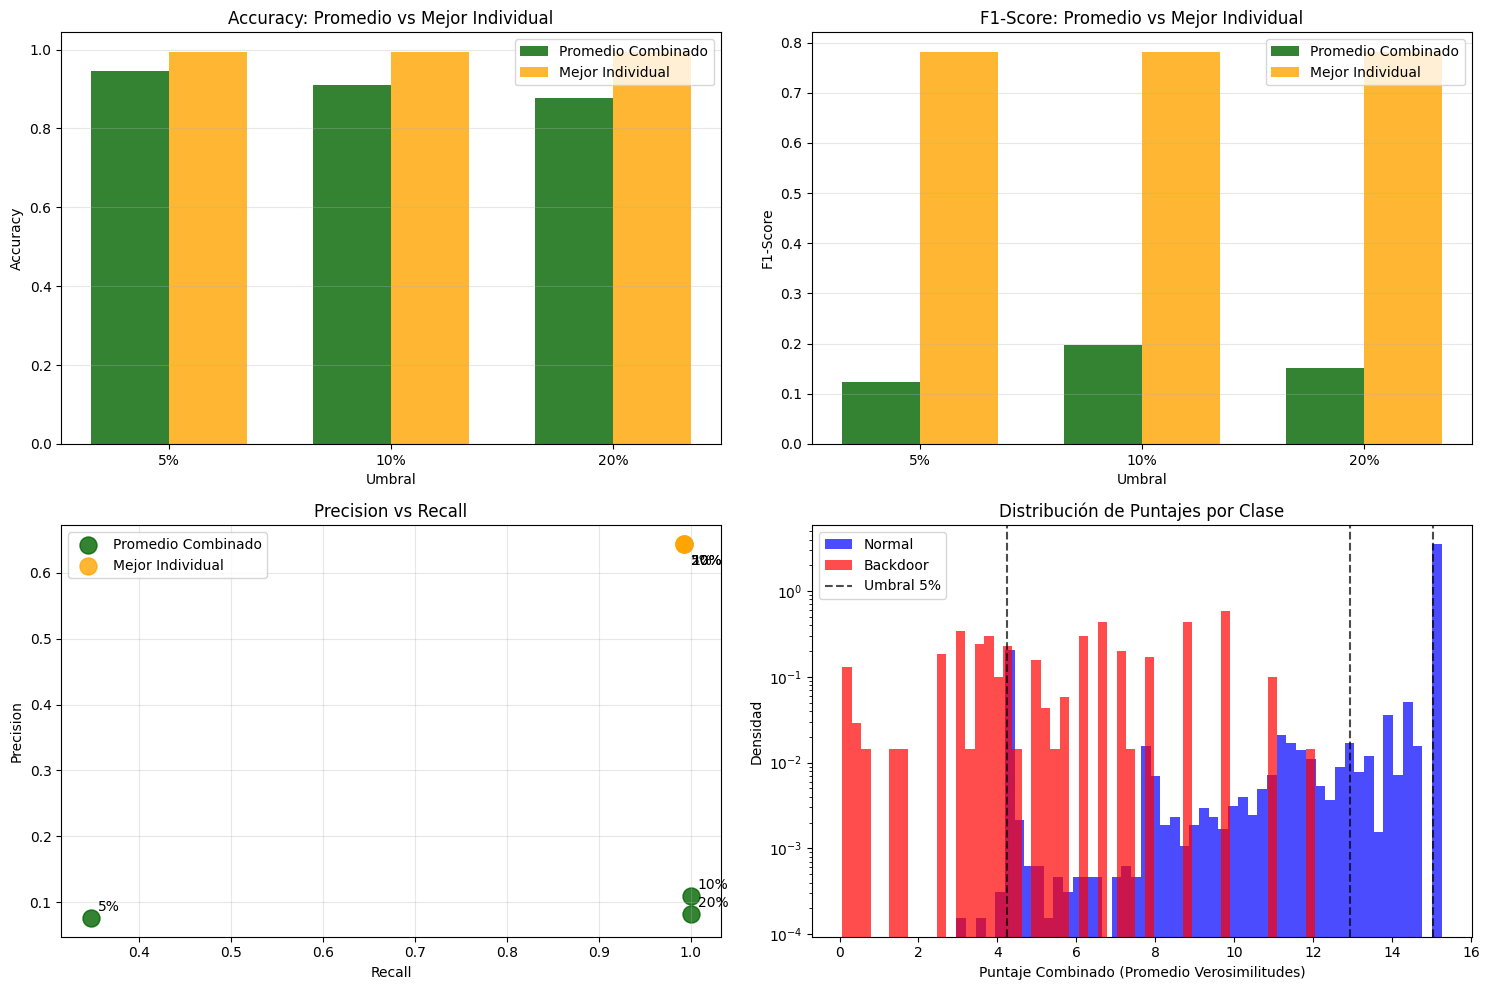


=== Analisis de resultados ===
Mejor resultado con promedio combinado:
  - Umbral: threshold_10%
  - Accuracy: 0.9110
  - F1-Score: 0.1966
  - Precision: 0.1090
  - Recall: 1.0000


In [17]:
# Comparación con resultados individuales
print(f"\n{'=' * 80}")
print("Comparación: individual vs promedio combinado")
print(f"{'=' * 80}")

# Tabla comparativa
comparison_data = []

# Agregar resultados del promedio combinado
for threshold_key, results in combined_results.items():
    comparison_data.append({
        'Método': 'PROMEDIO_5_CARACTERÍSTICAS',
        'Umbral': threshold_key,
        'Accuracy': results['accuracy'],
        'Precision': results['precision'],
        'Recall': results['recall'],
        'F1-Score': results['f1_score']
    })

# Agregar mejores resultados individuales para comparación
for threshold_key in ['threshold_5%', 'threshold_10%', 'threshold_20%']:
    # Encontrar la mejor característica individual para cada umbral
    best_individual = None
    best_f1 = -1

    for feature in top_5_features:
        if threshold_key in classification_results[feature]:
            f1 = classification_results[feature][threshold_key]['f1_score']
            if f1 > best_f1:
                best_f1 = f1
                best_individual = {
                    'feature': feature,
                    'results': classification_results[feature][threshold_key]
                }

    if best_individual:
        comparison_data.append({
            'Método': f'MEJOR_INDIVIDUAL_{best_individual["feature"][:15]}',
            'Umbral': threshold_key,
            'Accuracy': best_individual['results']['accuracy'],
            'Precision': best_individual['results']['precision'],
            'Recall': best_individual['results']['recall'],
            'F1-Score': best_individual['results']['f1_score']
        })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.round(4)

print("Tabla comparativa:")
display_dataframe_completely(comparison_df)

# Gráfico comparativo
plt.figure(figsize=(15, 10))

# Subplot 1: Accuracy
plt.subplot(2, 2, 1)
combined_data = comparison_df[comparison_df['Método'] == 'PROMEDIO_5_CARACTERÍSTICAS']
individual_data = comparison_df[comparison_df['Método'] != 'PROMEDIO_5_CARACTERÍSTICAS']

x_pos = np.arange(len(threshold_percentiles))
width = 0.35

plt.bar(x_pos - width / 2, combined_data['Accuracy'], width,
        label='Promedio Combinado', color='darkgreen', alpha=0.8)
plt.bar(x_pos + width / 2, individual_data['Accuracy'], width,
        label='Mejor Individual', color='orange', alpha=0.8)

plt.xlabel('Umbral')
plt.ylabel('Accuracy')
plt.title('Accuracy: Promedio vs Mejor Individual')
plt.xticks(x_pos, [f'{p}%' for p in threshold_percentiles])
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Subplot 2: F1-Score
plt.subplot(2, 2, 2)
plt.bar(x_pos - width / 2, combined_data['F1-Score'], width,
        label='Promedio Combinado', color='darkgreen', alpha=0.8)
plt.bar(x_pos + width / 2, individual_data['F1-Score'], width,
        label='Mejor Individual', color='orange', alpha=0.8)

plt.xlabel('Umbral')
plt.ylabel('F1-Score')
plt.title('F1-Score: Promedio vs Mejor Individual')
plt.xticks(x_pos, [f'{p}%' for p in threshold_percentiles])
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Subplot 3: Precision vs Recall - Combinado
plt.subplot(2, 2, 3)
plt.scatter(combined_data['Recall'], combined_data['Precision'],
            s=150, c='darkgreen', alpha=0.8, label='Promedio Combinado')
plt.scatter(individual_data['Recall'], individual_data['Precision'],
            s=150, c='orange', alpha=0.8, label='Mejor Individual')

for i, txt in enumerate([f'{p}%' for p in threshold_percentiles]):
    plt.annotate(txt, (combined_data.iloc[i]['Recall'], combined_data.iloc[i]['Precision']),
                 xytext=(5, 5), textcoords='offset points')
    plt.annotate(txt, (individual_data.iloc[i]['Recall'], individual_data.iloc[i]['Precision']),
                 xytext=(5, -15), textcoords='offset points')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision vs Recall')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 4: Distribución de puntajes por clase
plt.subplot(2, 2, 4)
normal_scores = combined_likelihood_scores[y_test_clean == 'normal.']
attack_scores = combined_likelihood_scores[y_test_clean == 'back.']

plt.hist(normal_scores, bins=50, alpha=0.7, label='Normal', color='blue', density=True)
plt.hist(attack_scores, bins=50, alpha=0.7, label='Backdoor', color='red', density=True)

# Agregar líneas de umbrales
for i, (perc, threshold) in enumerate(zip(threshold_percentiles, combined_thresholds)):
    plt.axvline(threshold, color='black', linestyle='--', alpha=0.7,
                label=f'Umbral {perc}%' if i == 0 else '')

plt.xlabel('Puntaje Combinado (Promedio Verosimilitudes)')
plt.ylabel('Densidad')
plt.title('Distribución de Puntajes por Clase')
plt.legend()
plt.yscale('log')  # Escala logarítmica para mejor visualización

plt.tight_layout()
plt.show()

print(f"\n=== Analisis de resultados ===")

# Encontrar mejor resultado combinado
best_combined = max(combined_results.items(), key=lambda x: x[1]['f1_score'])
best_threshold, best_metrics = best_combined

print(f"Mejor resultado con promedio combinado:")
print(f"  - Umbral: {best_threshold}")
print(f"  - Accuracy: {best_metrics['accuracy']:.4f}")
print(f"  - F1-Score: {best_metrics['f1_score']:.4f}")
print(f"  - Precision: {best_metrics['precision']:.4f}")
print(f"  - Recall: {best_metrics['recall']:.4f}")

In [18]:
# Comparar promedios de F1-Score
combined_avg_f1 = np.mean([r['f1_score'] for r in combined_results.values()])
individual_avg_f1 = np.mean([
    max([classification_results[feat][f'threshold_{p}%']['f1_score']
         for feat in top_5_features])
    for p in threshold_percentiles
])

print(f"F1-Score promedio - Combinado: {combined_avg_f1:.4f}")
print(f"F1-Score promedio - Mejor Individual: {individual_avg_f1:.4f}")

if combined_avg_f1 > individual_avg_f1:
    print(" El método combinado muestra mejor rendimiento promedio")
else:
    print(" Los métodos individuales muestran mejor rendimiento promedio")

F1-Score promedio - Combinado: 0.1576
F1-Score promedio - Mejor Individual: 0.7815
 Los métodos individuales muestran mejor rendimiento promedio


## Explicación del Codigo

Para este punto se definio la funcion llamada `calculate_combined_likelihood_scores` que se encarga de calcular el promedio de verosimilitudes para las cinco caracteristicas, para este efecto itera sobre cada una y obtiene los parametros del modelo exponencial como `scale` y `loc`, se obtienen los datos de prueba, se transforman datos si es necesario como valores no negativos y se calcula la verosimilitud con `stats.expon.pdf` y se suma a una variable que guarda las puntuaciones combinadas de cada caracteristica, finalmente esta divide el puntaje total encontrado por el número de caracteristicas para obtener el promedio.

Después de la definicion de la funcion anterior se preparan los datos de prueba en el cual se extraen los valores numericos por cada caracteristica y se validan que sean válidos y no NaN.

Lo siguiente es que se calcula los umbrales adaptativos, estos utilizan los mismos porcentajes de 5%, 10% y 20% del enunciado anterior y se calculan directamente de los percentiles de los puntajes combinados por medio de `np.percentile` y se guardan todos estos umbrales en una lista.

Finalmente, para el cálculo con los umbrales, se itera sobre cada uno y se determina por medio de la puntuacion de verosimilitud combinada si es mayor o igual al umbral, si este es mayor o igual es tráfico normal, de lo contrario es de tipo back. Se generan las metricas de accuracy, matriz de confusion, precision, recall, especificidad en conjunto con el F1-Score, para ser almacenados en una variable para su uso posterior.

Para generar una tabla de resumen, con base en los resultados guardados anteriormente se calcula cuál umbral obtuvo las mejores metricas y se compara con el mejor individual de los resultados anteriores. Además, se generan graficos que comparan el accuracy, F1-Score, precision y recall, asi como la distribucion de los puntajes combinados.

## Interpretación de Resultados

Se puede encontrar en los resultados que la mejor salida utilizando el promedio de verosimilitud fue el umbral de 10%, este obtuvo un accuracy de 0.9110, precision de 0.1090, recall de 1 y F1-Score de 0.1966, en general fue el mejor, solo su accuracy fue sobrepasado por el umbral 5%; sin embargo, el umbral 5% presenta algunas deficiencias en el precision y recall que lo hacen inferior al umbral 10%, de igual manera el resultado del umbral 20% empeora un poco con respecto al de 10%, sin embargo, es mejor que el de 5%. Los umbrales 10% y 20% tienen 1 de recall que es un buen resultado; sin embargo, la precision toma valores muy bajos posiblemente causando muchas falsas alarmas.

Cuando vamos a ver las matrices de confusion, para el umbral de 5% este no obtuvo tan malos resultados a pesar de sus metricas bajas dado que obtuvo verdaderos negativos en 25119, falsos positivos en 1231, falsos negativos en 189 y verdaderos positivos en 101. En comparacion con el umbral de mejores metricas que fue el de 10%, que obtuvo 23980 de verdaderos negativos, 2370 de falsos positivos, 0 de falsos negativos y 290 de verdaderos positivos. Comparando las matrices se puede observar que los falsos negativos disminuyen con los umbrales más altos, pero los falsos positivos tienden a aumentar conforme se aumenta el umbral.

Al compararlo con los resultados del paso anterior que utiliza la verosimilitud de cada caracteristica, se puede ver como es mucho mejor los resultados individuales de la caracteristica `hot` respecto a cualquier umbral utilizando los promedios de verosimilitud, ya que valores como accuracy, precision y F1-Score tienen un valor mucho más alto que la contraparte que usa el promedio de las cinco caracteristicas, el unico valor muy similar fue el recall.

Al ver que los resultados individuales como por ejemplo el mejor caso que fue `hot`, se puede ver como al utilizar el promedio de verosimilitud puede cambiar la eficiencia, ya que se utilizan caracteristicas menos discriminativas bajando su poder, especialmente se observó que caracteristicas como `service_http` que individualmente dio resultados pobres, es posible que esta y otras caracteristicas con bajos resultados hicieran los resultados bajaran un poco las metricas.

En el caso de utilizarlo en un sistema real, los resultados combinados proveen un muy buen recall que por medio de las pruebas podria perder muy pocos ataques reales; sin embargo, tiene muy poca precision lo que genera muchas falsas alarmas siendo detrimental en un sistema de deteccion.

En general para las pruebas realizadas lo mejor sería utilizar la caracteristica `hot` o alguna otra que obtuvo un resultado alto individualmente, los resultados con promedio no dieron resultados optimos por lo que no serían candidatos a utilizar en un sistema de deteccion para el dataset utilizado que fue el KDD99.